# A/B Testing: Evaluating New Recommendation Algorithms

**Author:**  

Pavel Grigoryev

**Project Description:**

- The ML team has developed new algorithms for news feed recommendations. 
- It is expected that these new algorithms will make users happier and the product more convenient/pleasant to use. 
- This needs to be verified.
- The ML team told us: "The recommendations make posts more interesting."

**Algorithms Under Test:**
1. **Similar to Liked Posts**: Shows users posts most similar to those they've liked
2. **Similar User Preferences**: Shows users posts that similar users have liked

**Goal:**

- To design and execute a complete A/B testing pipeline that validates whether the new recommendation algorithms increase user engagement.
- To provide data-driven recommendations on rolling out the algorithms to all users.

**Data Sources:**

The data is located in the ClickHouse table `feed_actions`.

**Main Conclusion:**

Hypothesis 1 ("Similar to Liked Posts"):
- **The new algorithm should not be rolled out to all users.**
- The analysis revealed anomalies (bimodality) in the test group, indicating a high probability of technical problems during the experiment.
- The main argument is that bimodality was present for the first 6 days but disappeared on the last day.
- If the impact on the test group was consistent for all 7 days, this could not have happened. This is a clear signal of technical issues.

Hypothesis 2 ("Posts Liked by Similar Users"):
- **Limited rollout recommended**
- Statistically significant CTR improvement observed (+0.0164)
- No distribution anomalies detected - results are reliable
- Clean data quality with consistent patterns across all test days

**Key Recommendations:**

For Hypothesis 1:
- Investigate the causes of bimodality in the test group.
    - It strongly resembles technical problems, given the presence of two modes around 10% and 30%.
    - Meanwhile, the historical CTR is around 20%.
    - This is a large deviation that is unlikely to occur under normal conditions.
- Take into account that bimodality was absent on the last test day. This might help in identifying the problem.

For Hypothesis 2:
- Gradually roll out the "Posts Liked by Similar Users" algorithm to increasingly larger audience segments
- Maintain close monitoring of key metrics and user behavior throughout the rollout process

# Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import hashlib
import statsmodels.stats.api as stm
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from textwrap import dedent
import sys
sys.path.append('../../assets')
import plotly_config 
import sql_config
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
%load_ext sql
%sql $sql_config.connection_string
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False
%config SqlMagic.autopandas = True

# Experimental Design

Two new recommendation algorithms were developed:

1) Show the user posts that are most similar to those they liked.
2) Show the user posts that were liked by users similar to them.

Let's formulate the hypotheses.

A well-formulated hypothesis should answer three questions:

- What are we changing?
- What will it affect?
- How do we measure it?

We need to determine how we will measure the effect.

We need to come up with a metric whose increase would indicate that the posts have truly become more interesting. What could this be (options):

- Time spent in the feed
- Number of posts viewed per unit of time
- Number of likes
- CTR from views to likes

We choose CTR because:

- There is a clear action that shows interest – the like
- It's a fairly standard metric (everyone does it and we're following suit)

Okay, we've fixed the metric. 

**Now let's formulate the hypotheses:**

1) If we implement the "posts similar to liked" recommendation algorithm, then user engagement will increase, resulting in higher CTR.
2) If we implement the "posts liked by similar users" recommendation algorithm, then user engagement will increase, resulting in higher CTR.


For the experiment results to be as accurate as possible, it's desirable to choose the statistical test before calculating group sizes.

Since we will use the Monte Carlo method, we need to use the same test that we will use for the final testing.

Let's look at the historical distribution of CTR.

In [2]:
%%sql df <<
SELECT 
    user_id
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr
FROM
    feed_actions
WHERE 
    toDate(time) < '2025-07-26'
GROUP BY
    user_id

Returning data to local variable df


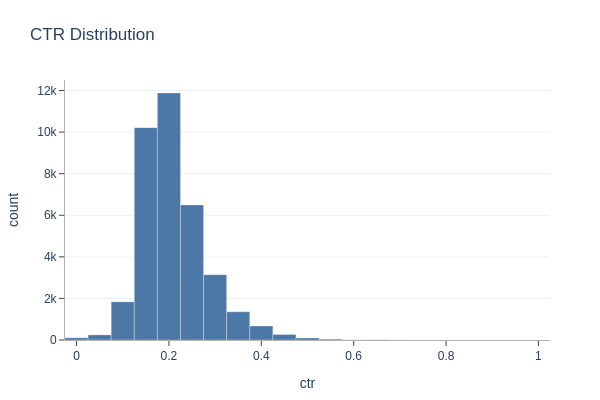

In [3]:
px.histogram(
    df
    , x='ctr'
    , nbins=50
    , title='CTR Distribution'
)

**Observations:**

- The distribution shows no obvious anomalies. There is slight asymmetry, but nothing critical for T-test is observed.

**Which statistical test do we choose for hypothesis testing?**

- Since the CTR distribution shows no strong asymmetry and is unimodal, T-test would be an appropriate choice.
- Since we want to compare groups, it's better not to use user-level CTR, but global CTR.
- To account for global CTR, we will use a linearized metric for group comparison.
- Therefore, we choose T-test on the linearized metric.

**What significance level do we choose?**

- We choose a significance level of 0.05

**What minimum effect do we want to detect?**

- We define MDE as a 0.01 percentage point change in CTR.

**What power do we want to have?**

- We need power above 0.8
- Ideally more than 0.9, if the number of users is sufficient for such power.

Now we need to split users into groups.
What we expect from group splitting:

We want:

- splitting to be random
- each user's group not to change during the experiment
- the splitting method to be deterministic (so that if needed, the splitting can be exactly reproduced)


**How will we divide users into groups?**

- Users in the table already have a group label.
- Users were divided into groups using hashing with salt
- The first hypothesis has groups:
  - exp_group = 1 - Everything as before
  - exp_group = 2 - "Similar to liked posts" recommendations
- The second hypothesis has groups:
  - exp_group = 0 - Everything as before
  - exp_group = 3 - "Posts liked by similar users" recommendations

Example of hashing with salt.

In [4]:
def ab_split(id, salt='exp_mess_1', n_groups=4):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [5]:
df['group'] = df['user_id'].apply(ab_split)

In [6]:
df.head()

,user_id,likes,views,ctr,group
0,13289,17,105,0.16,3
1,121096,10,63,0.16,1
2,5090,15,93,0.16,2
3,4394,105,270,0.39,3
4,12577,23,84,0.27,2


In [7]:
df['group'].value_counts()

group
1    9284
2    9123
0    9022
3    8947
Name: count, dtype: int64

# Data Description

The data is located in the ClickHouse table `feed_actions`.

Table feed_actions

Field | Description
-|-
user_id | User ID
post_id | Post ID
action | Action: view or like
time | Timestamp
gender | User's gender
age | User's age (1 = Female)
country | User's country
city | User's city
os | User's OS
source | Traffic source
exp_group | A/B test group

# Helper Functions

We will create a function that outputs the necessary information about the DataFrame.

In [8]:
def info(df):
    print(f'Full duplicates: {df.duplicated().sum()}')
    display(df.describe(include='all').T)
    display(df.apply(lambda x: x.duplicated().sum()).to_frame('Dupl').T)
    display(df.isna().sum().to_frame('Miss').T)
    display((df.select_dtypes(np.number) == 0).sum().to_frame('Zeros').T)
    display((df.select_dtypes(np.number) < 0).sum().to_frame('Negs').T)

Create a function for smoothing CTR.

In [9]:
def apply_smoothed_ctr(group, alpha=5):
    global_ctr = group['likes'].sum() / group['views'].sum()
    return (group['likes'] + alpha * global_ctr) / (group['views'] + alpha)

Create a function that will:
- display distributions in groups
- check the correctness of splitting
- use the chi-square test to check group equality by number of users

In [10]:
def check_split_correctness(df, alpha=0.05) -> None:
    """
    Check the correctness of user splitting into test and control groups.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns 'user_id' and 'group'
    alpha : float, default=0.05
        Significance level for statistical tests
    """
    print("=== SPLITTING CORRECTNESS CHECK ===\n")
    
    # Check 1: User uniqueness
    print("1. USER UNIQUENESS CHECK:")
    print("Checking that there are no users present in both groups simultaneously.")
    
    users_in_both_groups = (df.groupby('user_id').group.nunique() > 1).sum()
    
    if users_in_both_groups == 0:
        print("✅ SUCCESS: No users found in both groups simultaneously.")
        print(f"   Number of users in both groups: {users_in_both_groups}")
    else:
        print("❌ ERROR: Users found in both groups!")
        print(f"   Number of such users: {users_in_both_groups}")
        print("   This indicates a problem in the splitting system.")
    
    print("\n" + "="*50 + "\n")
    
    # Check 2: Group balance
    print("2. GROUP SIZE BALANCE CHECK:")
    print(dedent("""
    - H0: The number of users in test and control groups is equal
    - H1: The number of users in test and control groups is not equal
    """))
    print(f"We choose a significance level of {alpha}.")
    print('We use the chi-square goodness-of-fit test.')
    
    users_by_group = df['group'].value_counts()
    total_users = users_by_group.sum()
    expected_counts = [total_users/2, total_users/2]  # Expected equal distribution
    
    # Perform chi-square test
    chi2_stat, p_value = stats.chisquare(users_by_group.values, f_exp=expected_counts)
    
    print(f"Observed counts: {dict(users_by_group)}")
    print(f"Expected counts (equal distribution): {expected_counts}")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Calculate percentage difference
    group_names = users_by_group.index.tolist()
    count_a, count_b = users_by_group.values
    percent_diff = abs(count_a - count_b) / total_users * 100
    
    print(f"Percentage difference: {percent_diff:.2f}%")
    
    if p_value < alpha:
        print('❌ REJECT H0: The number of users in test and control groups is NOT equal.')
        print('   This may indicate splitting system issues.')
    else:
        print('✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.')
        print('   Group sizes are balanced statistically.')
    
    print("\n" + "="*50)
    print("SUMMARY:")
    
    # Overall assessment
    issues = []
    if users_in_both_groups > 0:
        issues.append(f"- {users_in_both_groups} users in both groups")
    if p_value < alpha:
        issues.append(f"- Significant group size imbalance (p={p_value:.4f})")
    if percent_diff > 5:  # More than 5% difference
        issues.append(f"- Large percentage difference: {percent_diff:.2f}%")
    
    if not issues:
        print("✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.")
    else:
        print("❌ ISSUES FOUND:")
        for issue in issues:
            print(issue)
        print("\nRecommendation: Investigate the splitting mechanism.")


Create a function for calculating power using the Monte Carlo method.

In [11]:
def monte_carlo_power(data_a, data_b, test_func, alpha=0.05, n_sim=10_000, 
                     effect_size=None, random_seed=None):
    """
    Universal power estimation using Monte Carlo method
    
    Parameters:
    -----------
    data_a : array-like
        Data for group A (baseline)
    data_b : array-like
        Data for group B (with or without effect)
    test_func : function
        Statistical test function (should return p-value)
    alpha : float
        Significance level
    n_sim : int
        Number of simulations
    effect_size : float or None
        Effect size to add (if None, observed effect is used)
    random_seed : int
        Seed for reproducibility
    
    Returns:
    --------
    power : float
        Power estimate
    results : dict
        Detailed results dictionary
    effect_sizes : array
        Distribution of effect sizes
    p_values : array
        Distribution of p-values     
    """
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_a = len(data_a)
    n_b = len(data_b)
    
    # Observed effect (if not explicitly specified)
    if effect_size is None:
        effect_size = np.mean(data_b) - np.mean(data_a)
    
    rejects = 0
    effect_sizes = []
    p_values = []
    
    for _ in tqdm(range(n_sim)):
        # Bootstrap original data
        boot_a = np.random.choice(data_a, size=n_a, replace=True)
        boot_b = np.random.choice(data_b, size=n_b, replace=True)
        
        # Add effect to group B (in linearized units)
        if effect_size != 0:
            boot_b = boot_b + effect_size
        
        # Apply the same test used for decision making
        pval = test_func(boot_a, boot_b)
        
        # Collect statistics
        current_effect = np.mean(boot_b) - np.mean(boot_a)
        effect_sizes.append(current_effect)
        p_values.append(pval)
        
        if pval < alpha:
            rejects += 1
    
    power = rejects / n_sim
    
    # Additional information
    results = {
        'power': power,
        'effect_size': effect_size,
        'mean_effect': np.mean(effect_sizes),
        'effect_std': np.std(effect_sizes),
        'mean_pvalue': np.mean(p_values),
        'n_sim': n_sim,
        'sample_size_a': n_a,
        'sample_size_b': n_b
    }
    
    return power, results, effect_sizes, p_values

Create a function for T-test to pass to the power calculation function.

In [12]:
def pg_ttest(
    data_a
    , data_b
    ):
    return pg.ttest(data_a, data_b, correction=True)['p-val'].iloc[0]

Let's create a function that displays the ECDF of the p-values.

In [13]:
def plot_pvalue_ecdf(pvalues, title='P-value Distribution and ECDF', subplot_titles=[]):
    """
    Plot ECDF and histogram of p-values for uniformity assessment.
    
    This function creates a two-panel plot showing:
    - Left: Histogram of p-values (should be uniform under null hypothesis)
    - Right: Empirical CDF of p-values (should follow diagonal line under null)
    
    Parameters:
    -----------
    pvalues : array-like
        Array of p-values from statistical tests
    title : str, optional
        Main title for the entire plot
    subplot_titles : list, optional
        Titles for individual subplots [left_title, right_title]
    """
    # Create subplots with 1 row and 2 columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=subplot_titles)
    
    # Left panel: Histogram of p-values
    # Under null hypothesis, p-values should be uniformly distributed
    hist = px.histogram(pvalues, nbins=30, histnorm='probability density')
    fig.add_traces(hist.data, rows=1, cols=1)
    
    # Right panel: Empirical CDF of p-values  
    # Under null hypothesis, ECDF should follow the diagonal line
    ecdf = px.ecdf(pvalues)
    fig.add_traces(ecdf.data, rows=1, cols=2)
    
    # Add reference lines for visual comparison
    
    # Left panel: Horizontal line at y=1 (expected uniform density)
    fig.add_shape(
        type="line",
        x0=0, y0=1,
        x1=1, y1=1,
        line=dict(dash="dash"),
        row=1, col=1
    )    
    
    # Right panel: Diagonal line from (0,0) to (1,1) (expected ECDF under null)
    fig.add_shape(
        type="line",
        x0=0, y0=0,
        x1=1, y1=1,
        line=dict(dash="dash"),
        row=1, col=2
    )
    
    # Configure axes labels
    fig.update_xaxes(title_text='p-value', title_standoff=7)
    fig.update_yaxes(title_text='Density', row=1, col=1) 
    fig.update_yaxes(title_text='Probability', row=1, col=2, title_standoff=7)    
    
    # Final layout adjustments
    fig.update_layout(width=1000, showlegend=False, title=title)
    
    return fig

Create a function for t-test on the linearized metric.

In [14]:
def ttest_linearized(df):
    """
    Perform t-test on linearized metric with automatic variance check and correction
    """
    # Use global CTR from the control group as reference
    global_ctr = df[df['group'] == 'control']['likes'].sum() / df[df['group'] == 'control']['views'].sum()
    
    # For each user, create a linearized metric by subtracting expected from actual
    df['linearized_likes'] = df['likes'] - df['views'] * global_ctr
    
    print("Linearized metric created using global CTR from control group")
    print(f"Global CTR: {global_ctr:.4f}")
    df_control = df[df.group == 'control']
    df_test = df[df.group == 'test']
    observed_diff = df_test['likes'].sum() / df_test['views'].sum() - df_control['likes'].sum() / df_control['views'].sum()    
    print(f"Difference in Global CTR (test - control): {observed_diff:.4f}")
    # Examine the distribution
    fig = px.histogram(
        df,
        x='linearized_likes',
        color='group',
        barmode='overlay',
        title='Linearized Likes Distribution by Group'
    )
    fig.show()
    
    # Formulate hypotheses
    print("Formulate hypotheses:")
    print("- H0: Mean value of the linearized metric in control and test groups are equal")
    print("- H1: Mean value of the linearized metric in control and test groups are not equal")
    print()
    
    # Set significance level
    alpha = 0.05
    print(f"Significance level: {alpha}")
    print()
    
    # Check variance homogeneity
    homoscedasticity_test = pg.homoscedasticity(df, dv='linearized_likes', group='group')
    print("Variance homogeneity test (Levene's test):")
    display(homoscedasticity_test)
    print()
    
    equal_var = homoscedasticity_test['pval'].iloc[0] >= alpha
    
    if equal_var:
        print("Variances are equal (p-value ≥ 0.05) - using standard t-test without correction")
        correction = False
    else:
        print("Variances are not equal (p-value < 0.05) - using Welch's t-test with correction")
        correction = True
    
    print()
    
    # Extract data for groups
    linearized_likes_control = df[df['group'] == 'control'].linearized_likes
    linearized_likes_test = df[df['group'] == 'test'].linearized_likes
    
    # Examine the difference in mean values
    mean_diff = linearized_likes_test.mean() - linearized_likes_control.mean()
    print(f"Difference in means (test - control): {mean_diff:.4f}")
    print()
    
    # Perform t-test
    ttest_result = pg.ttest(linearized_likes_test, linearized_likes_control, correction=correction)
    
    print("T-test results:")
    display(ttest_result)
    
    p_value = ttest_result['p-val'].iloc[0]
    
    print("\nConclusion:")
    if p_value < alpha:
        print(f"REJECT H0: p-value ({p_value:.4f}) < {alpha} - Significant difference detected")
    else:
        print(f"FAIL TO REJECT H0: p-value ({p_value:.4f}) ≥ {alpha} - No significant difference")

# Sample Size Determination

Now we need to conduct an A/A test.

We need to determine the sample size for the A/A test.

We will determine the sample size using the Monte Carlo method based on historical data.

## Group Size for Hypothesis 1

We plan to run the experiment for 1 week, so we'll take:

It's important not only to determine the sample size in advance, but also preferable that the test period be fixed and the same for both the A/A test and the A/B test.

Therefore, we'll take historical data from the week before the start of the A/A test.

In [15]:
%%sql df <<
SELECT 
    multiIf(
        exp_group = 1, 'control'
        , exp_group = 2, 'test'
        , 'unknown'
    ) as group
    , user_id
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr
FROM
    feed_actions
WHERE 
    toDate(time) BETWEEN '2025-07-19' and '2025-07-25'
    and exp_group in (1, 2)
GROUP BY
    group
    , user_id

Returning data to local variable df


Check the correctness of splitting.

In [16]:
check_split_correctness(df)

=== SPLITTING CORRECTNESS CHECK ===

1. USER UNIQUENESS CHECK:
Checking that there are no users present in both groups simultaneously.
✅ SUCCESS: No users found in both groups simultaneously.
   Number of users in both groups: 0


2. GROUP SIZE BALANCE CHECK:

- H0: The number of users in test and control groups is equal
- H1: The number of users in test and control groups is not equal

We choose a significance level of 0.05.
We use the chi-square goodness-of-fit test.
Observed counts: {'control': np.int64(6548), 'test': np.int64(6545)}
Expected counts (equal distribution): [np.float64(6546.5), np.float64(6546.5)]
Chi-square statistic: 0.0007
P-value: 0.9791
Percentage difference: 0.02%
✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.
   Group sizes are balanced statistically.

SUMMARY:
✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.


Check if the number of users who came during the week before the A/A test is sufficient for us.

Calculate linearized metrics.

In [17]:
df_linearized = df[['group', 'views', 'likes']].copy()

In [18]:
global_ctr = (
    df_linearized[df_linearized['group'] == 'control']['likes'].sum() 
    / df_linearized[df_linearized['group'] == 'control']['views'].sum()
)
df_linearized['linearized_likes'] = df_linearized['likes'] - df_linearized['views'] * global_ctr
linearized_likes_control = df_linearized[df_linearized['group'] == 'control'].linearized_likes
linearized_likes_test = df_linearized[df_linearized['group'] == 'test'].linearized_likes

Calculate MDE for the linearized metric.

The MDE of the linearized metric scales by the mean value of the denominator relative to the MDE of the original ratio metric.

In [19]:
mde = 0.01
mean_views = df_linearized[df_linearized['group'] == 'control']['views'].mean()  
mde_linearized = mean_views * mde  
mde_linearized

np.float64(0.6881078191814295)

Calculate the power of T-test on the linearized metric.

In [20]:
power, results, effect_sizes, p_values = monte_carlo_power(
    data_a=linearized_likes_control
    , data_b=linearized_likes_test
    , test_func=pg_ttest
    , alpha=0.05
    , n_sim=10_000
    , effect_size=mde_linearized
)
display(results)

100%|██████████| 10000/10000 [01:18<00:00, 128.12it/s]


{'power': 1.0,
 'effect_size': np.float64(0.6881078191814295),
 'mean_effect': np.float64(0.6745717491698086),
 'effect_std': np.float64(0.08720452271781552),
 'mean_pvalue': np.float64(6.680173140404055e-08),
 'n_sim': 10000,
 'sample_size_a': 6548,
 'sample_size_b': 6545}

**Observations:**

- The resulting power is greater than 0.9
- Therefore, 6500 users in each group is sufficient for us.
- Therefore, we will conduct the A/A test for hypothesis 1 for at least one week and ensure at least 6500 users are collected.

## Group Size for Hypothesis 2

We'll proceed similarly to hypothesis 1 for hypothesis 2.

In [21]:
%%sql df <<
SELECT 
    multiIf(
        exp_group = 0, 'control'
        , exp_group = 3, 'test'
        , 'unknown'
    ) as group
    , user_id
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr
FROM
    feed_actions
WHERE 
    toDate(time) BETWEEN '2025-07-19' and '2025-07-25'
    and exp_group in (0, 3)
GROUP BY
    group
    , user_id

Returning data to local variable df


Check the correctness of splitting.

In [22]:
check_split_correctness(df)

=== SPLITTING CORRECTNESS CHECK ===

1. USER UNIQUENESS CHECK:
Checking that there are no users present in both groups simultaneously.
✅ SUCCESS: No users found in both groups simultaneously.
   Number of users in both groups: 0


2. GROUP SIZE BALANCE CHECK:

- H0: The number of users in test and control groups is equal
- H1: The number of users in test and control groups is not equal

We choose a significance level of 0.05.
We use the chi-square goodness-of-fit test.
Observed counts: {'test': np.int64(6647), 'control': np.int64(6521)}
Expected counts (equal distribution): [np.float64(6584.0), np.float64(6584.0)]
Chi-square statistic: 1.2057
P-value: 0.2722
Percentage difference: 0.96%
✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.
   Group sizes are balanced statistically.

SUMMARY:
✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.


Check if the number of users who came during the week before the A/A test is sufficient for us.

Calculate linearized metrics.

In [23]:
df_linearized = df[['group', 'views', 'likes']].copy()

In [24]:
global_ctr = (
    df_linearized[df_linearized['group'] == 'control']['likes'].sum() 
    / df_linearized[df_linearized['group'] == 'control']['views'].sum()
)
df_linearized['linearized_likes'] = df_linearized['likes'] - df_linearized['views'] * global_ctr
linearized_likes_control = df_linearized[df_linearized['group'] == 'control'].linearized_likes
linearized_likes_test = df_linearized[df_linearized['group'] == 'test'].linearized_likes

Calculate MDE for the linearized metric.

The MDE of the linearized metric scales by the mean value of the denominator relative to the MDE of the original ratio metric.

In [25]:
mde = 0.01
mean_views = df_linearized[df_linearized['group'] == 'control']['views'].mean()  
mde_linearized = mean_views * mde  
mde_linearized

np.float64(0.6842094770740684)

Calculate the power of T-test on the linearized metric.

In [26]:
power, results, effect_sizes, p_values = monte_carlo_power(
    data_a=linearized_likes_control
    , data_b=linearized_likes_test
    , test_func=pg_ttest
    , alpha=0.05
    , n_sim=10_000
    , effect_size=mde_linearized
)
display(results)

100%|██████████| 10000/10000 [01:18<00:00, 127.66it/s]


{'power': 0.9999,
 'effect_size': np.float64(0.6842094770740684),
 'mean_effect': np.float64(0.5084212002342425),
 'effect_std': np.float64(0.08676260020186066),
 'mean_pvalue': np.float64(5.0276496102241296e-05),
 'n_sim': 10000,
 'sample_size_a': 6521,
 'sample_size_b': 6647}

**Observations:**

- The resulting power is greater than 0.9
- Therefore, the number of users in each group who came during the week before the A/A test is sufficient for us.
- Therefore, we will conduct the A/A test for hypothesis 2 for at least one week and ensure at least 6500 users are collected.

# Analysis of A/A Test Results

A/A test ran from `2025-07-26` to `2025-08-01`

## Hypothesis 1

Get the data.

In [27]:
%%sql df <<
SELECT 
    multiIf(
        exp_group = 1, 'control'
        , exp_group = 2, 'test'
        , 'unknown'
    ) as group
    , user_id
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr
FROM
    feed_actions
WHERE 
    toDate(time) BETWEEN '2025-07-26' and '2025-08-01'
    and exp_group in (1, 2)
GROUP BY
    group
    , user_id

Returning data to local variable df


Check the correctness of splitting.

In [28]:
check_split_correctness(df)

=== SPLITTING CORRECTNESS CHECK ===

1. USER UNIQUENESS CHECK:
Checking that there are no users present in both groups simultaneously.
✅ SUCCESS: No users found in both groups simultaneously.
   Number of users in both groups: 0


2. GROUP SIZE BALANCE CHECK:

- H0: The number of users in test and control groups is equal
- H1: The number of users in test and control groups is not equal

We choose a significance level of 0.05.
We use the chi-square goodness-of-fit test.
Observed counts: {'control': np.int64(8491), 'test': np.int64(8362)}
Expected counts (equal distribution): [np.float64(8426.5), np.float64(8426.5)]
Chi-square statistic: 0.9874
P-value: 0.3204
Percentage difference: 0.77%
✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.
   Group sizes are balanced statistically.

SUMMARY:
✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.


Conduct the test.

Linearized metric created using global CTR from control group
Global CTR: 0.2108
Difference in Global CTR (test - control): 0.0010


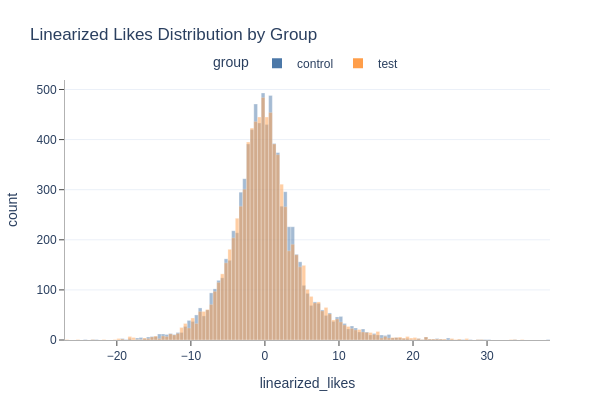

Formulate hypotheses:
- H0: Mean value of the linearized metric in control and test groups are equal
- H1: Mean value of the linearized metric in control and test groups are not equal

Significance level: 0.05

Variance homogeneity test (Levene's test):


,W,pval,equal_var
levene,0.02,0.88,True



Variances are equal (p-value ≥ 0.05) - using standard t-test without correction

Difference in means (test - control): 0.0680

T-test results:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.86,16851,two-sided,0.39,"[-0.09, 0.22]",0.01,0.025,0.14



Conclusion:
FAIL TO REJECT H0: p-value (0.3878) ≥ 0.05 - No significant difference


In [29]:
ttest_linearized(df)

A/A test for hypothesis 1 completed successfully, no statistically significant differences between groups were found.

Check if the group sizes during the A/A test week are sufficient for the A/B test.

Calculate linearized metrics.

In [30]:
df_linearized = df[['group', 'views', 'likes']].copy()

In [31]:
global_ctr = (
    df_linearized[df_linearized['group'] == 'control']['likes'].sum() 
    / df_linearized[df_linearized['group'] == 'control']['views'].sum()
)
df_linearized['linearized_likes'] = df_linearized['likes'] - df_linearized['views'] * global_ctr
linearized_likes_control = df_linearized[df_linearized['group'] == 'control'].linearized_likes
linearized_likes_test = df_linearized[df_linearized['group'] == 'test'].linearized_likes

Calculate MDE for the linearized metric.

The MDE of the linearized metric scales by the mean value of the denominator relative to the MDE of the original ratio metric.

In [32]:
mde = 0.01
mean_views = df_linearized[df_linearized['group'] == 'control']['views'].mean()  
mde_linearized = mean_views * mde  
mde_linearized

np.float64(0.7047144034860441)

Calculate the power of T-test on the linearized metric.

In [33]:
power, results, effect_sizes, p_values = monte_carlo_power(
    data_a=linearized_likes_control
    , data_b=linearized_likes_test
    , test_func=pg_ttest
    , alpha=0.05
    , n_sim=10_000
    , effect_size=mde_linearized
)
display(results)

100%|██████████| 10000/10000 [01:22<00:00, 121.62it/s]


{'power': 1.0,
 'effect_size': np.float64(0.7047144034860441),
 'mean_effect': np.float64(0.7739889597895855),
 'effect_std': np.float64(0.07862503800587009),
 'mean_pvalue': np.float64(9.033169205926269e-13),
 'n_sim': 10000,
 'sample_size_a': 8491,
 'sample_size_b': 8362}


**Observations:**

- The resulting power is greater than 0.9
- Therefore, approximately 8500 users in each group who came during the A/A test week is sufficient for us.
- Therefore, we will conduct the A/B test for hypothesis 1 for at least one week and ensure at least 8500 users are collected.

## Hypothesis 2

Get the data.

In [34]:
%%sql df <<
SELECT 
    multiIf(
        exp_group = 0, 'control'
        , exp_group = 3, 'test'
        , 'unknown'
    ) as group
    , user_id
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr
FROM
    feed_actions
WHERE 
    toDate(time) BETWEEN '2025-07-26' and '2025-08-01'
    and exp_group in (0, 3)
GROUP BY
    group
    , user_id

Returning data to local variable df


Check the correctness of splitting.

In [35]:
check_split_correctness(df)

=== SPLITTING CORRECTNESS CHECK ===

1. USER UNIQUENESS CHECK:
Checking that there are no users present in both groups simultaneously.
✅ SUCCESS: No users found in both groups simultaneously.
   Number of users in both groups: 0


2. GROUP SIZE BALANCE CHECK:

- H0: The number of users in test and control groups is equal
- H1: The number of users in test and control groups is not equal

We choose a significance level of 0.05.
We use the chi-square goodness-of-fit test.
Observed counts: {'test': np.int64(8425), 'control': np.int64(8328)}
Expected counts (equal distribution): [np.float64(8376.5), np.float64(8376.5)]
Chi-square statistic: 0.5616
P-value: 0.4536
Percentage difference: 0.58%
✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.
   Group sizes are balanced statistically.

SUMMARY:
✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.


Conduct the test.

Linearized metric created using global CTR from control group
Global CTR: 0.2119
Difference in Global CTR (test - control): -0.0005


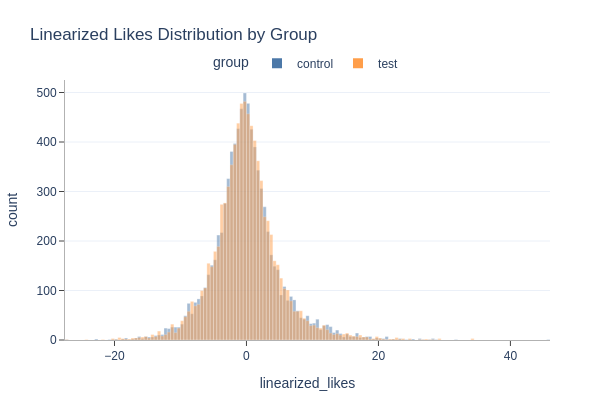

Formulate hypotheses:
- H0: Mean value of the linearized metric in control and test groups are equal
- H1: Mean value of the linearized metric in control and test groups are not equal

Significance level: 0.05

Variance homogeneity test (Levene's test):


,W,pval,equal_var
levene,0.26,0.61,True



Variances are equal (p-value ≥ 0.05) - using standard t-test without correction

Difference in means (test - control): -0.0337

T-test results:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.42,16751,two-sided,0.67,"[-0.19, 0.12]",0.01,0.019,0.07



Conclusion:
FAIL TO REJECT H0: p-value (0.6736) ≥ 0.05 - No significant difference


In [36]:
ttest_linearized(df)

A/A test for hypothesis 2 completed successfully, no statistically significant differences between groups were found.

Check if the group sizes during the A/A test week are sufficient for the A/B test.

Calculate linearized metrics.

In [37]:
df_linearized = df[['group', 'views', 'likes']].copy()

In [38]:
global_ctr = (
    df_linearized[df_linearized['group'] == 'control']['likes'].sum() 
    / df_linearized[df_linearized['group'] == 'control']['views'].sum()
)
df_linearized['linearized_likes'] = df_linearized['likes'] - df_linearized['views'] * global_ctr
linearized_likes_control = df_linearized[df_linearized['group'] == 'control'].linearized_likes
linearized_likes_test = df_linearized[df_linearized['group'] == 'test'].linearized_likes

Calculate MDE for the linearized metric.

The MDE of the linearized metric scales by the mean value of the denominator relative to the MDE of the original ratio metric.

In [39]:
mde = 0.01
mean_views = df_linearized[df_linearized['group'] == 'control']['views'].mean()  
mde_linearized = mean_views * mde  
mde_linearized

np.float64(0.7036443323727185)

Calculate the power of T-test on the linearized metric.

In [40]:
power, results, effect_sizes, p_values = monte_carlo_power(
    data_a=linearized_likes_control
    , data_b=linearized_likes_test
    , test_func=pg_ttest
    , alpha=0.05
    , n_sim=10_000
    , effect_size=mde_linearized
)
display(results)

100%|██████████| 10000/10000 [01:21<00:00, 122.12it/s]


{'power': 1.0,
 'effect_size': np.float64(0.7036443323727185),
 'mean_effect': np.float64(0.6701341105424857),
 'effect_std': np.float64(0.08047631368856027),
 'mean_pvalue': np.float64(7.217972572258684e-10),
 'n_sim': 10000,
 'sample_size_a': 8328,
 'sample_size_b': 8425}

**Observations:**

- The resulting power is greater than 0.9
- Therefore, approximately 8500 users in each group who came during the A/A test week is sufficient for us.
- Therefore, we will conduct the A/B test for hypothesis 2 for at least one week and ensure at least 8500 users are collected.

# Analysis of A/B Test Results for Hypothesis 1

A/B test ran from `2025-08-02` to `2025-08-08`

## Data Loading

Get the data.

In [41]:
%%sql df <<
WITH user_first_visit AS (
    SELECT 
        user_id
        , min(toDate(time)) as first_date
    FROM 
        feed_actions
    GROUP BY 
        user_id
)
, exp_data as (
    SELECT 
        multiIf(
            exp_group = 1, 'control'
            , exp_group = 2, 'test'
            , 'unknown'
        ) as group
        , argMax(multiIf(
            gender = 1, 'female'
            , gender = 0, 'male'
            , 'unknown'
        ), time) as gender
        , argMax(multiIf(
            age < 25, '<25'
            , age between 25 and 40, '25-40'
            , age between 41 and 55, '41-55' 
            , age >= 56, '56+'
            , 'unknown'
        ), time) as age_group      
        , argMax(source, time) as source
        , argMax(os, time) as os
        , argMax(country, time) as country
        , argMax(city, time) as city
        , user_id
        , uniq(post_id) as posts
        , countIf(action = 'like') as likes
        , countIf(action = 'view') as views
        , ifNull(likes / nullIf(views, 0), 0) as ctr
        , uniq(toDate(time)) as days
    FROM
        feed_actions
    WHERE 
        toDate(time) BETWEEN '2025-08-02' and '2025-08-08'
        and exp_group in (1, 2)
    GROUP BY
        group
        , user_id
)
SELECT
        ed.*
        , if(ufv.first_date >= '2025-08-02', 'new', 'existing') as user_status
FROM
    exp_data ed
    LEFT JOIN user_first_visit ufv ON ed.user_id = ufv.user_id

Returning data to local variable df


Let's save the dataframe for use in the supplement.

In [42]:
df_for_supplement = df.copy()

In [43]:
%%sql df_daily <<
SELECT 
    toDate(time) as date
    , user_id
    , uniq(post_id) as posts
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr    
    , multiIf(
        exp_group = 1, 'control'
        , exp_group = 2, 'test'
        , 'unknown'
    ) as group
    , argMax(multiIf(
        gender = 1, 'female'
        , gender = 0, 'male'
        , 'unknown'
    ), time) as gender
    , argMax(multiIf(
        age < 25, '<25'
        , age between 25 and 40, '25-40'
        , age between 41 and 55, '41-55' 
        , age >= 56, '56+'
        , 'unknown'
    ), time) as age_group    
    , argMax(source, time) as source
    , argMax(os, time) as os
    , argMax(country, time) as country
    , argMax(city, time) as city
FROM
    feed_actions
WHERE 
    toDate(time) BETWEEN '2025-08-02' and '2025-08-08'
    and exp_group in (1, 2)
GROUP BY
    date
    , user_id
    , group
ORDER BY
    date    

Returning data to local variable df_daily


Convert the date to datetime.

In [44]:
df_daily['date'] = pd.to_datetime(df_daily['date'])

In [45]:
df.head(3)

,group,gender,age_group,source,os,country,city,user_id,posts,likes,views,ctr,days,user_status
0,test,female,25-40,organic,Android,Russia,Berezniki,127977,101,12,129,0.09,3,existing
1,control,female,<25,ads,Android,Russia,Noginsk,31954,37,8,50,0.16,1,new
2,control,male,<25,ads,Android,Russia,Tomsk,33061,81,16,102,0.16,2,new


In [46]:
df_daily.head(3)

,date,user_id,posts,likes,views,ctr,group,gender,age_group,source,os,country,city
0,2025-08-02,110599,18,6,18,0.33,test,female,41-55,organic,iOS,Russia,Borisoglebsk
1,2025-08-02,132529,17,3,17,0.18,control,female,41-55,organic,Android,Russia,Vologda
2,2025-08-02,4612,39,8,47,0.17,control,male,<25,ads,iOS,Russia,Moscow


In [47]:
df.dtypes

group           object
gender          object
age_group       object
source          object
os              object
country         object
city            object
user_id          int64
posts            int64
likes            int64
views            int64
ctr            float64
days             int64
user_status     object
dtype: object

In [48]:
df_daily.dtypes

date         datetime64[ns]
user_id               int64
posts                 int64
likes                 int64
views                 int64
ctr                 float64
group                object
gender               object
age_group            object
source               object
os                   object
country              object
city                 object
dtype: object

Replace the data type for dimensions with categorical.

In [49]:
df['group'] = df['group'].astype('category')
df['gender'] = df['gender'].astype('category')
df['age_group'] = df['age_group'].astype('category')
df['source'] = df['source'].astype('category')
df['os'] = df['os'].astype('category')
df['country'] = df['country'].astype('category')
df['city'] = df['city'].astype('category')
df['user_status'] = df['user_status'].astype('category')

In [50]:
df_daily['group'] = df_daily['group'].astype('category')
df_daily['gender'] = df_daily['gender'].astype('category')
df_daily['age_group'] = df_daily['age_group'].astype('category')
df_daily['source'] = df_daily['source'].astype('category')
df_daily['os'] = df_daily['os'].astype('category')
df_daily['country'] = df_daily['country'].astype('category')
df_daily['city'] = df_daily['city'].astype('category')

## Data Exploration

Explore DataFrame.

In [51]:
info(df)

Full duplicates: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
group,19897,2,control,10020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,19897,2,female,11007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_group,19897,4,<25,10379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,19897,2,organic,10579,NaN,NaN,NaN,NaN,NaN,NaN,NaN
os,19897,2,Android,12859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,19897,11,Russia,17455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,19897,2117,Moscow,2701,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,"19,897.00",NaN,NaN,NaN,"75,513.14","53,254.93",206.00,"21,945.00","109,319.00","126,146.00","140,740.00"
posts,"19,897.00",NaN,NaN,NaN,52.03,29.99,1.00,29.00,46.00,70.00,202.00
likes,"19,897.00",NaN,NaN,NaN,13.69,10.88,0.00,6.00,11.00,19.00,93.00


,group,gender,age_group,source,os,country,city,user_id,posts,likes,views,ctr,days,user_status
Dupl,19895,19895,19893,19895,19895,19886,17780,0,19714,19815,19616,17105,19890,19895


,group,gender,age_group,source,os,country,city,user_id,posts,likes,views,ctr,days,user_status
Miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,user_id,posts,likes,views,ctr,days
Zeros,0,0,121,0,121,0


,user_id,posts,likes,views,ctr,days
Negs,0,0,0,0,0,0


**Observations:**

- Everything is fine.
- Null values are present where they are acceptable.
- There are no duplicates in user_id.
- 2 groups.
- The minimum value in views is not 0.
- There are no negative values.

### Checking the Correctness of the Splitting

Check the correctness of splitting.

In [52]:
check_split_correctness(df)

=== SPLITTING CORRECTNESS CHECK ===

1. USER UNIQUENESS CHECK:
Checking that there are no users present in both groups simultaneously.
✅ SUCCESS: No users found in both groups simultaneously.
   Number of users in both groups: 0


2. GROUP SIZE BALANCE CHECK:

- H0: The number of users in test and control groups is equal
- H1: The number of users in test and control groups is not equal

We choose a significance level of 0.05.
We use the chi-square goodness-of-fit test.
Observed counts: {'control': np.int64(10020), 'test': np.int64(9877)}
Expected counts (equal distribution): [np.float64(9948.5), np.float64(9948.5)]
Chi-square statistic: 1.0277
P-value: 0.3107
Percentage difference: 0.72%
✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.
   Group sizes are balanced statistically.

SUMMARY:
✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.


### User Distribution

Let's examine how users are distributed across dimensions.

**By Test Group**

Let's check how users are distributed across groups.

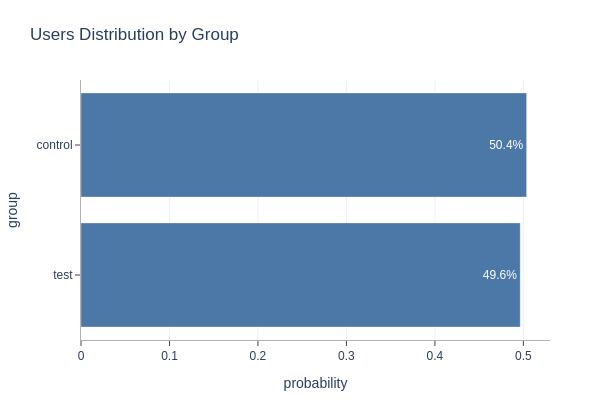

In [53]:
px.histogram(
    df
    , y='group'
    , histnorm='probability'
    , text_auto='.1%'
    , title='Users Distribution by Group'
)

**Observations:**

- Approximately equal distribution across groups.

**By User Status (New or Not)**

Let's check how users are distributed by new user status.

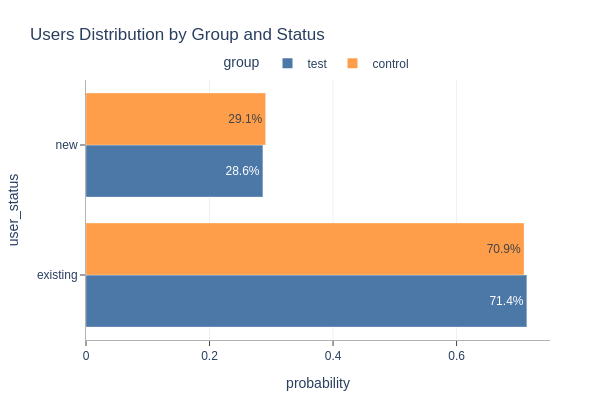

In [54]:
px.histogram(
    df
    , y='user_status'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Status'
)

**Observations:**

- Both groups have about 29% new users (first appeared during the test).
- The ratio between groups is approximately the same.

**By Gender**

Let's check how users are distributed by gender.

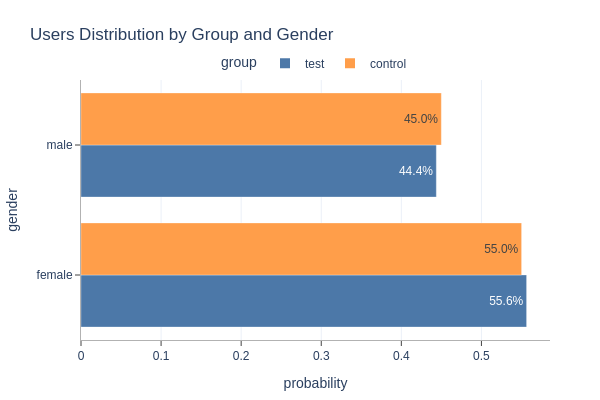

In [55]:
px.histogram(
    df
    , y='gender'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Gender'
)

**Observations:**

- There are more women in both groups.
- The ratio between groups is approximately the same.

**By Age Group**

Let's check how users are distributed across age groups.

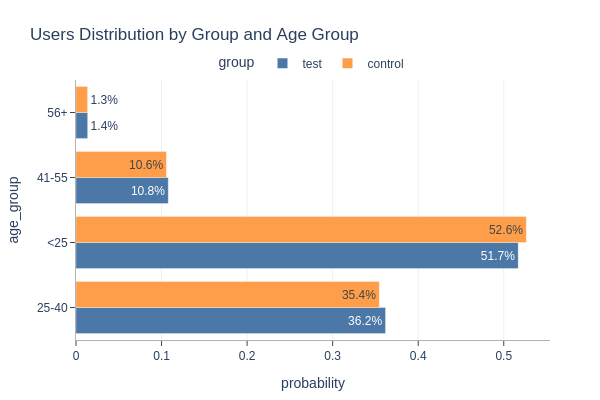

In [56]:
px.histogram(
    df
    , y='age_group'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Age Group'
)

**Observations:**

- Users under 25 are the largest group in both groups.
- 25-40 years old is the second largest.
- The ratio in each age category is approximately the same between groups.

**By OS**

Let's check how users are distributed by OS.

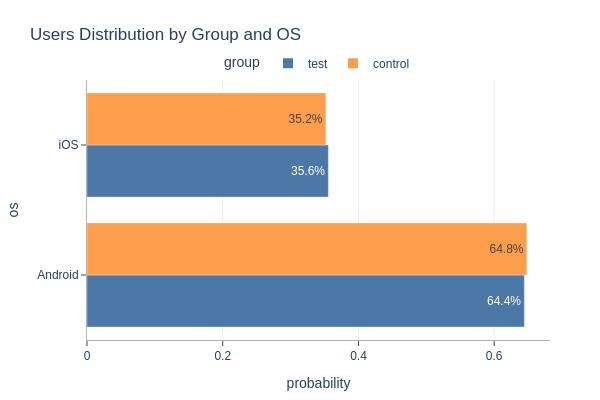

In [57]:
px.histogram(
    df
    , y='os'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and OS'
)

**Observations:**

- There are more Android users in both groups.
- The distribution between groups is approximately the same.


**By Source**

Let's check how users are distributed by traffic source.

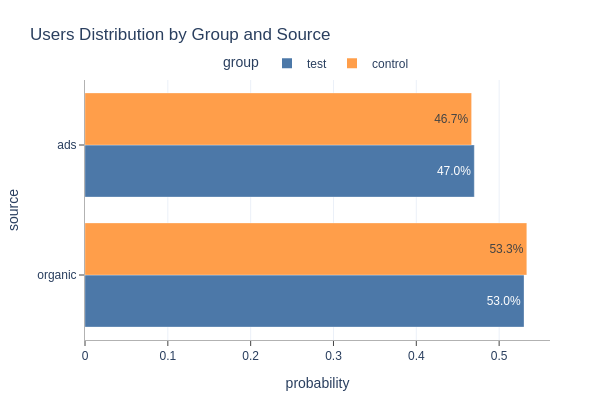

In [58]:
px.histogram(
    df
    , y='source'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Source'
)

**Observations:**

- Organic traffic is slightly higher than paid traffic.
- The distribution between groups is approximately the same.


**By Country**

Let's check how users are distributed by country.

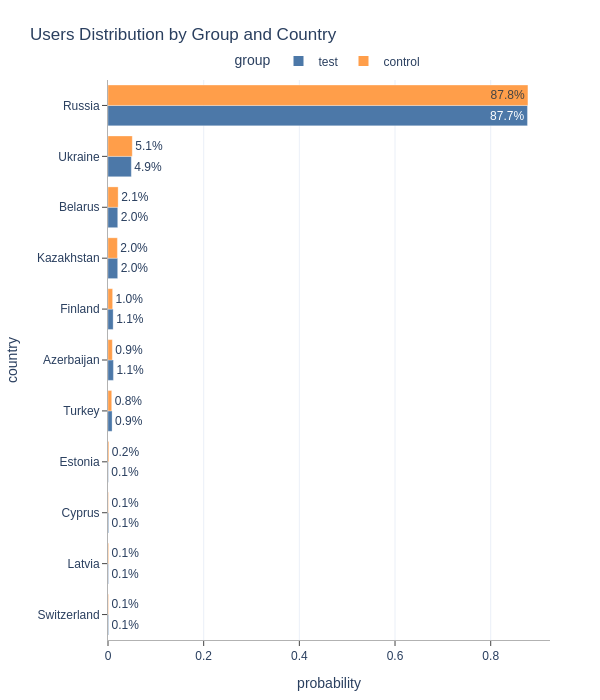

In [59]:
px.histogram(
    df
    , y='country'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Country'
    , height=700
).update_layout(
    legend_y=1.06
    , yaxis={'categoryorder': 'total ascending'}
)

**Observations:**

- Most users are from Russia.
- The distribution between groups is approximately the same.


**By Top Cities**

Let's check how users are distributed across top cities.

In [60]:
top_cities = df['city'].value_counts().nlargest(10).index

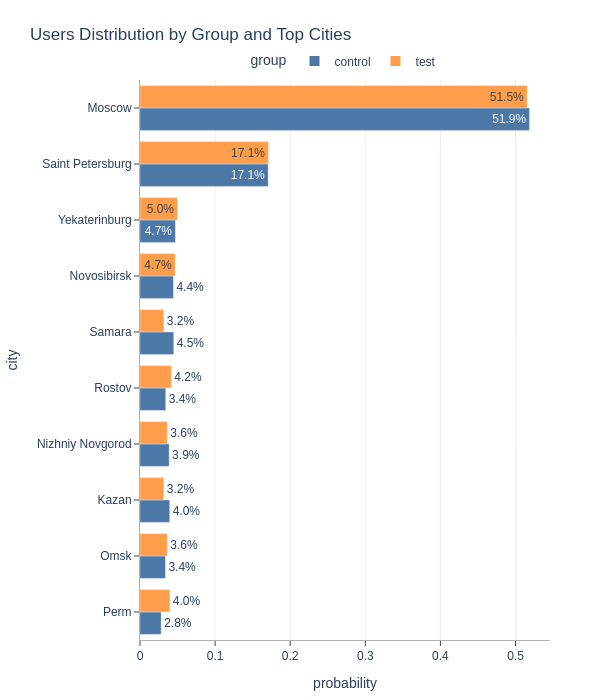

In [61]:
px.histogram(
    df[df['city'].isin(top_cities)]
    , y='city'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Top Cities'
    , height=700
).update_layout(
    legend_y=1.06
    , yaxis={'categoryorder': 'total ascending'}
)

**Observations:**

- Most users are from Moscow and St. Petersburg.
- The distribution between groups is similar.

### Distribution of Post Count

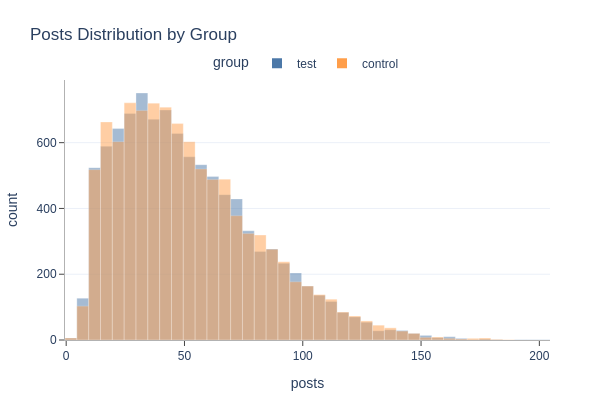

In [62]:
px.histogram(
    df
    , x='posts'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='Posts Distribution by Group'
)

**Observations:**

- Nothing unusual.

### Distribution of Likes Count

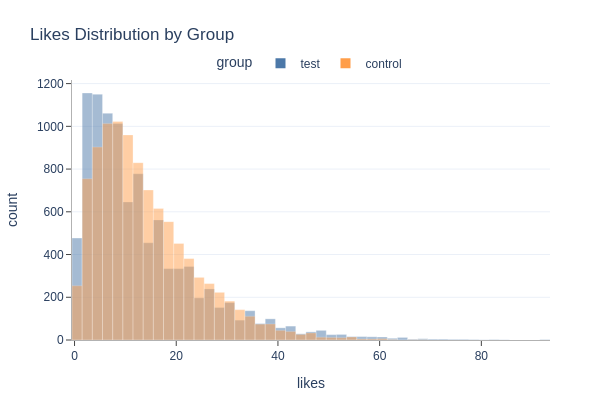

In [63]:
px.histogram(
    df
    , x='likes'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='Likes Distribution by Group'
)

**Observations:**

- The distribution of likes in the control group is slightly shifted to the right compared to the test group.

### Distribution of Views

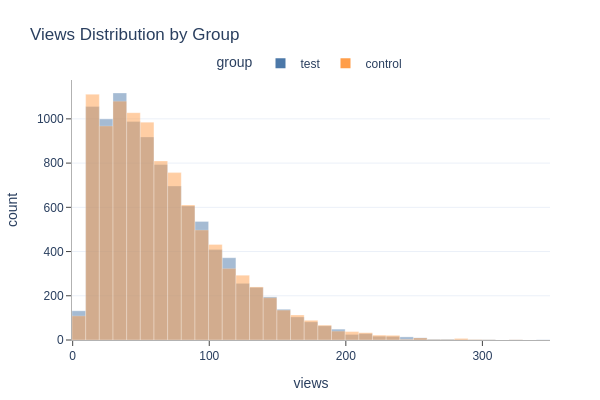

In [64]:
px.histogram(
    df
    , x='views'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='Views Distribution by Group'
)

**Observations:**

- Nothing unusual.

### Distribution of CTR

Let's examine how CTR is distributed across groups.

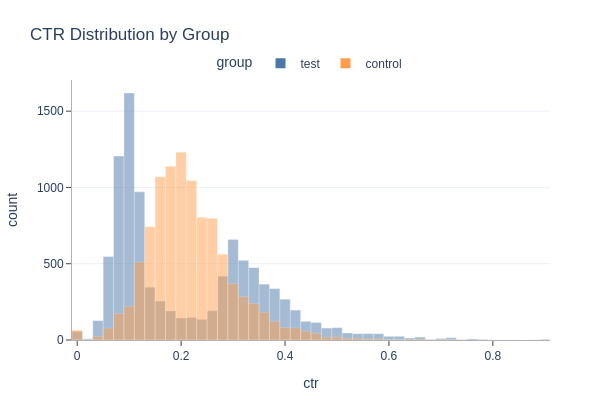

In [65]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='CTR Distribution by Group'
)

**Observations:**

- In the control group, the distribution resembles normal.
- In the test group, there is a bimodal distribution. This is clearly strange.
- Bimodal distribution often indicates the presence of two different populations.

Let's examine across different dimensions. Need to determine if bimodality appears in all dimensions or not.

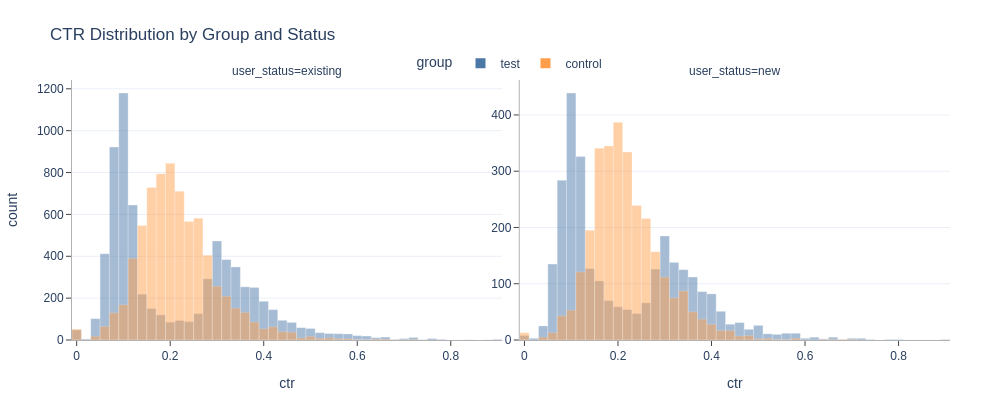

In [66]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , facet_col='user_status'
    , barmode='overlay'
    , nbins=50
    , width=1000
    , title='CTR Distribution by Group and Status'
).update_yaxes(matches=None, showticklabels=True)

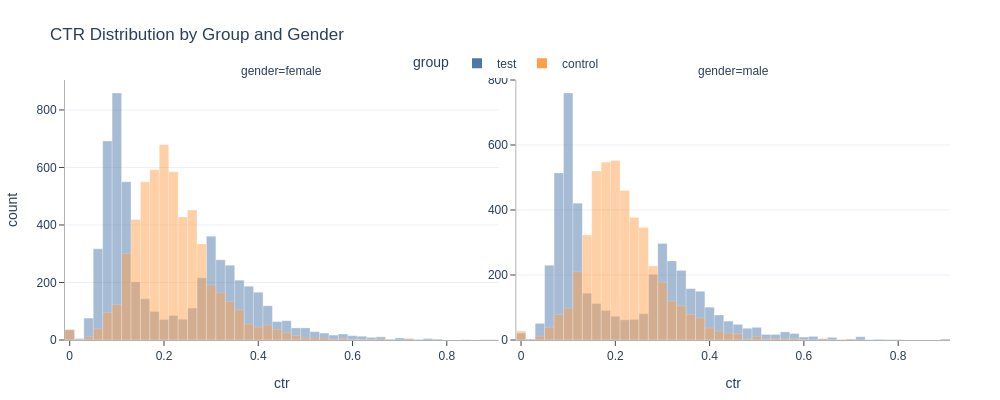

In [67]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , facet_col='gender'
    , barmode='overlay'
    , nbins=50
    , width=1000
    , title='CTR Distribution by Group and Gender'
).update_yaxes(matches=None, showticklabels=True)

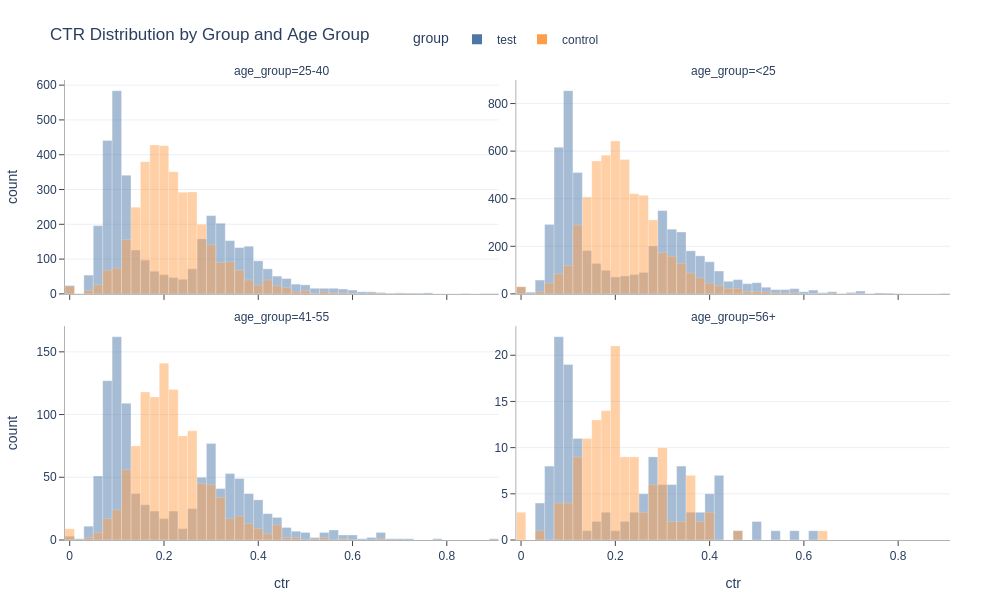

In [68]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , facet_col='age_group'
    , facet_col_wrap=2
    , barmode='overlay'
    , nbins=50
    , width=1000
    , height=600
    , title='CTR Distribution by Group and Age Group'
).update_yaxes(matches=None, showticklabels=True)

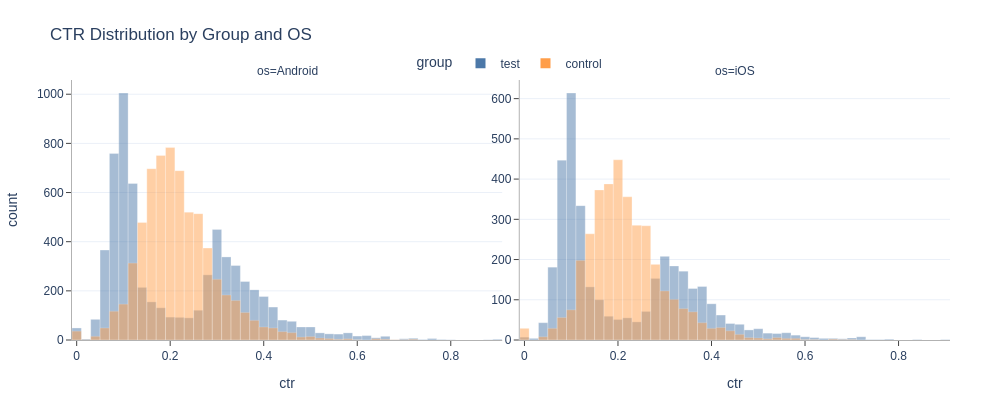

In [69]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , facet_col='os'
    , barmode='overlay'
    , nbins=50
    , width=1000
    , title='CTR Distribution by Group and OS'
).update_yaxes(matches=None, showticklabels=True)

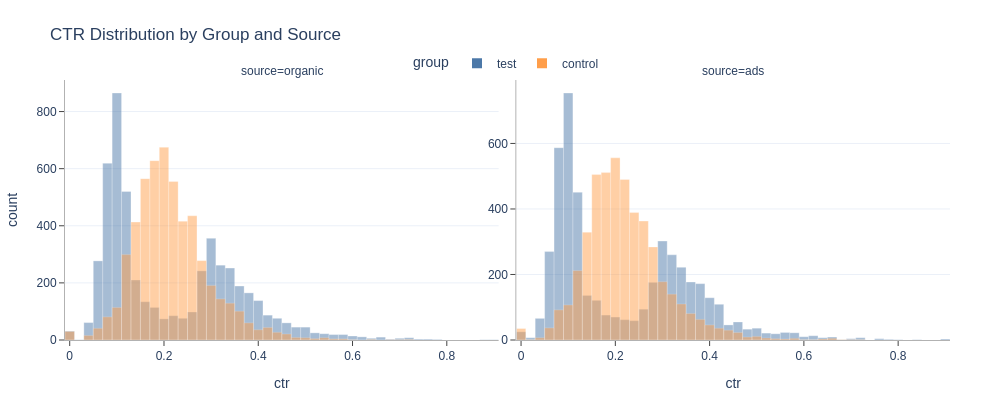

In [70]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , facet_col='source'
    , barmode='overlay'
    , nbins=50
    , width=1000
    , title='CTR Distribution by Group and Source'
).update_yaxes(matches=None, showticklabels=True)

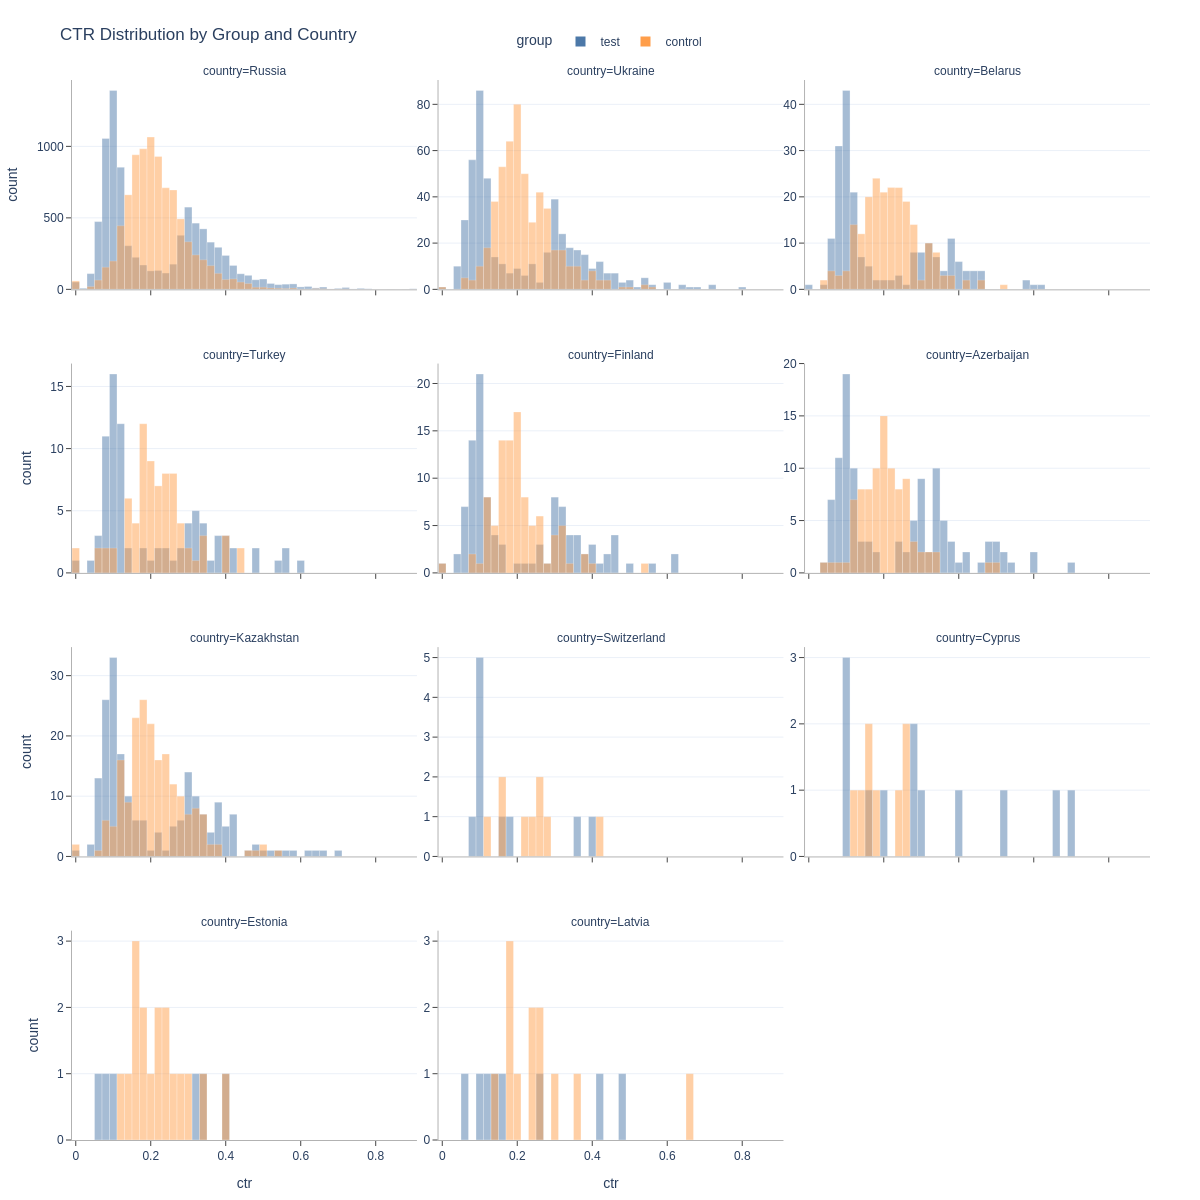

In [71]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , facet_col='country'
    , facet_col_wrap=3
    , barmode='overlay'
    , nbins=50
    , width=1200
    , height=1200
    , title='CTR Distribution by Group and Country'
).update_yaxes(matches=None, showticklabels=True).update_layout(legend_y=1.05)

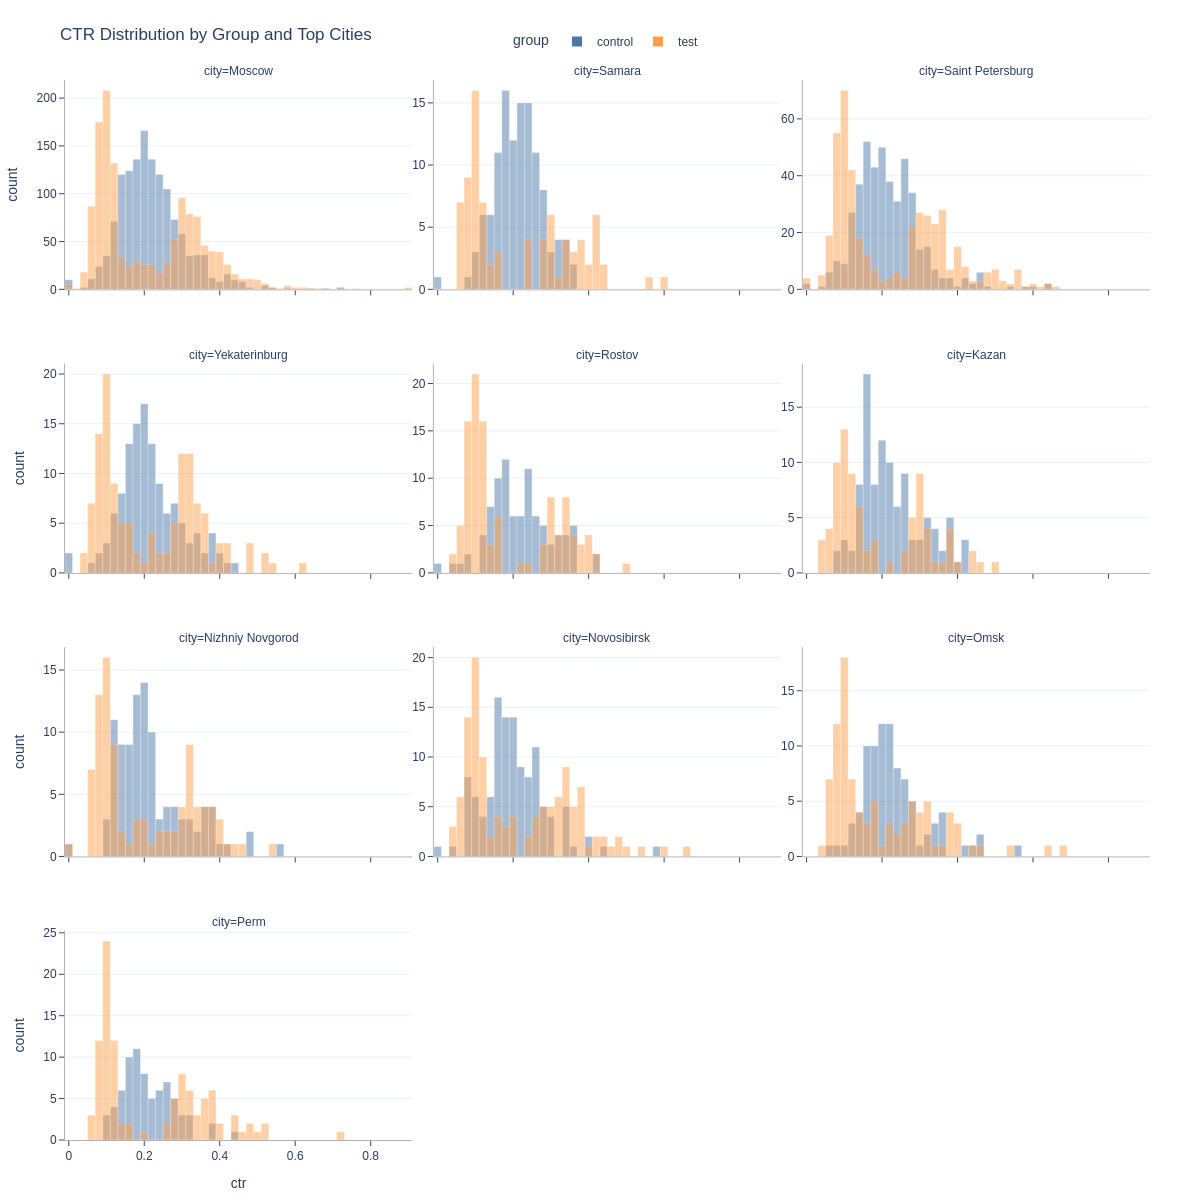

In [72]:
px.histogram(
    df[df['city'].isin(top_cities)]
    , x='ctr'
    , color='group'
    , facet_col='city'
    , facet_col_wrap=3
    , barmode='overlay'
    , nbins=50
    , width=1200
    , height=1200
    , title='CTR Distribution by Group and Top Cities'
).update_yaxes(matches=None, showticklabels=True).update_layout(legend_y=1.05)

**Observations:**

- Bimodality appears in all dimensions.

### Daily Dynamics

Let's try to find the cause of the bimodality.

Let's examine how metrics changed by day.

Aggregate data by day.

In [73]:
df_for_fig = (
    df_daily.groupby(['date', 'group'], observed=True, as_index=False)
    .agg(
        users = ('user_id', 'nunique')
        , views = ('views', 'sum')
        , likes = ('likes', 'sum')
    )
)
df_for_fig['ctr'] = df_for_fig['likes'] / df_for_fig['views']
df_for_fig['views_per_user'] = df_for_fig['views'] / df_for_fig['users']
df_for_fig['likes_per_user'] = df_for_fig['likes'] / df_for_fig['users']

Build charts.

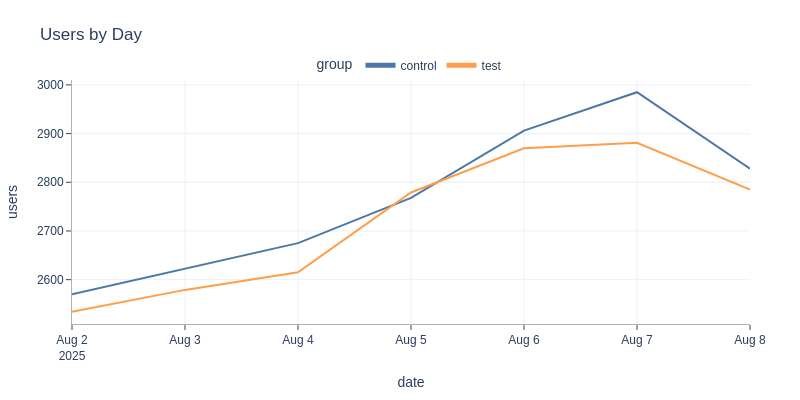

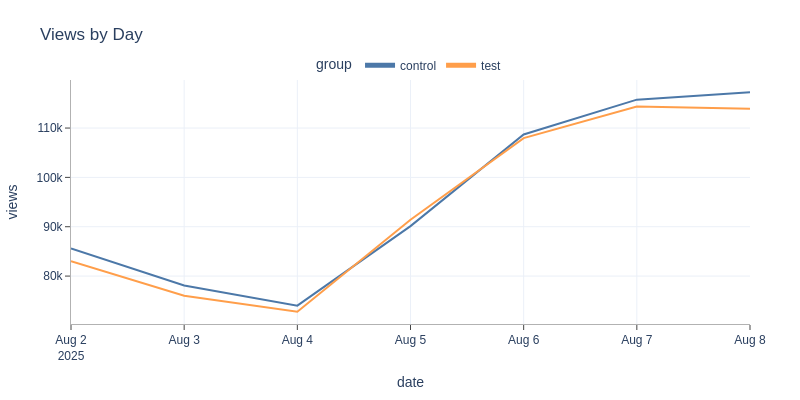

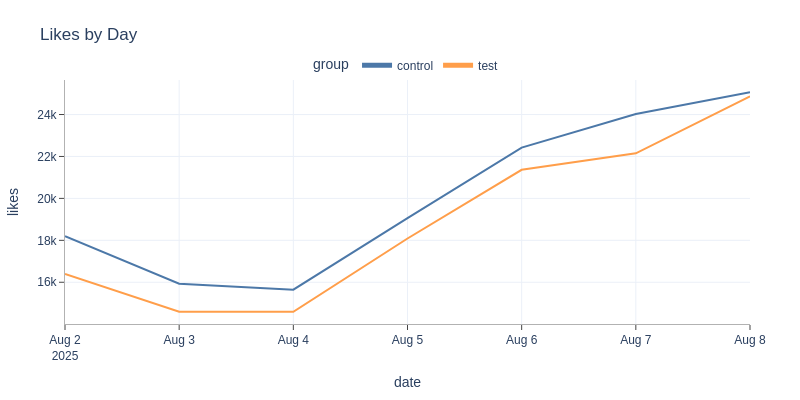

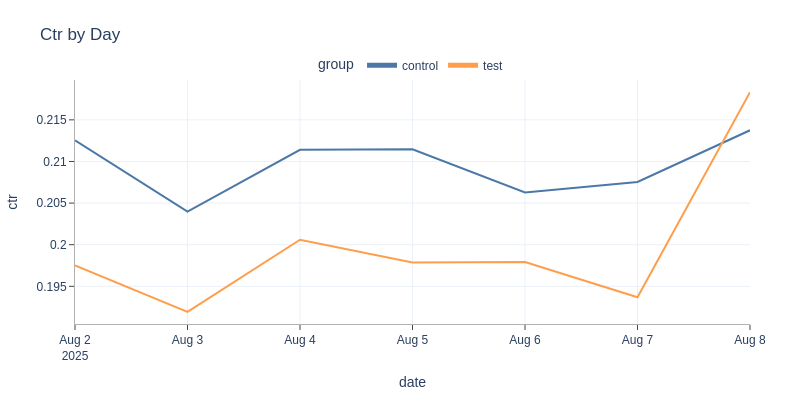

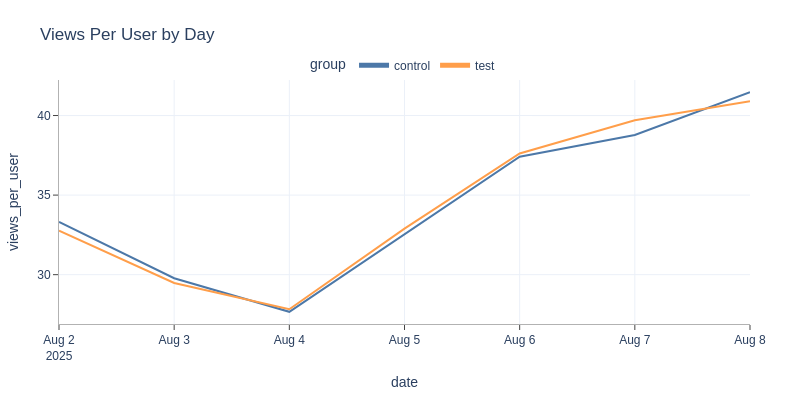

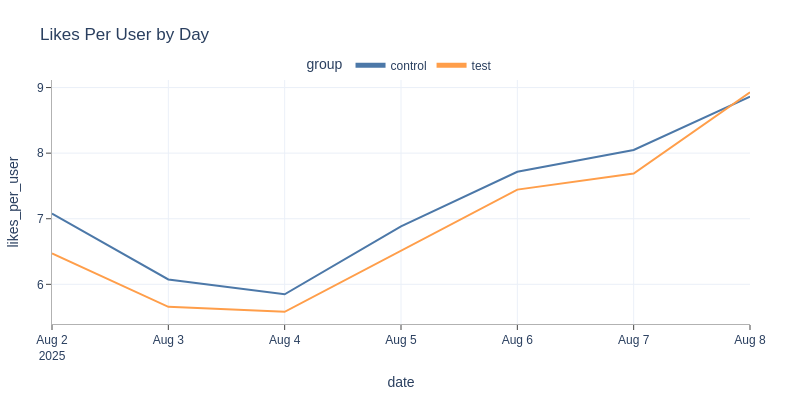

In [74]:
for metric in ['users', 'views', 'likes', 'ctr', 'views_per_user', 'likes_per_user']:
    px.line(
        df_for_fig
        , x='date'
        , y=metric
        , color='group'
        , width=800
        , title=f"{metric.replace('_', ' ').title()} by Day"
    ).show()

**Observations:**

- The number of users grew daily, except for the last day.
- CTR changed slightly.
- Other metrics decreased until August 4, then increased.
- The control group had slightly more users per day.
- The number of views per day was similar between groups.
- The number of likes in the test group was lower every day.
- CTR was also lower every day, except the last day.

### CTR Distribution by Day

Let's examine how CTR was distributed each day.

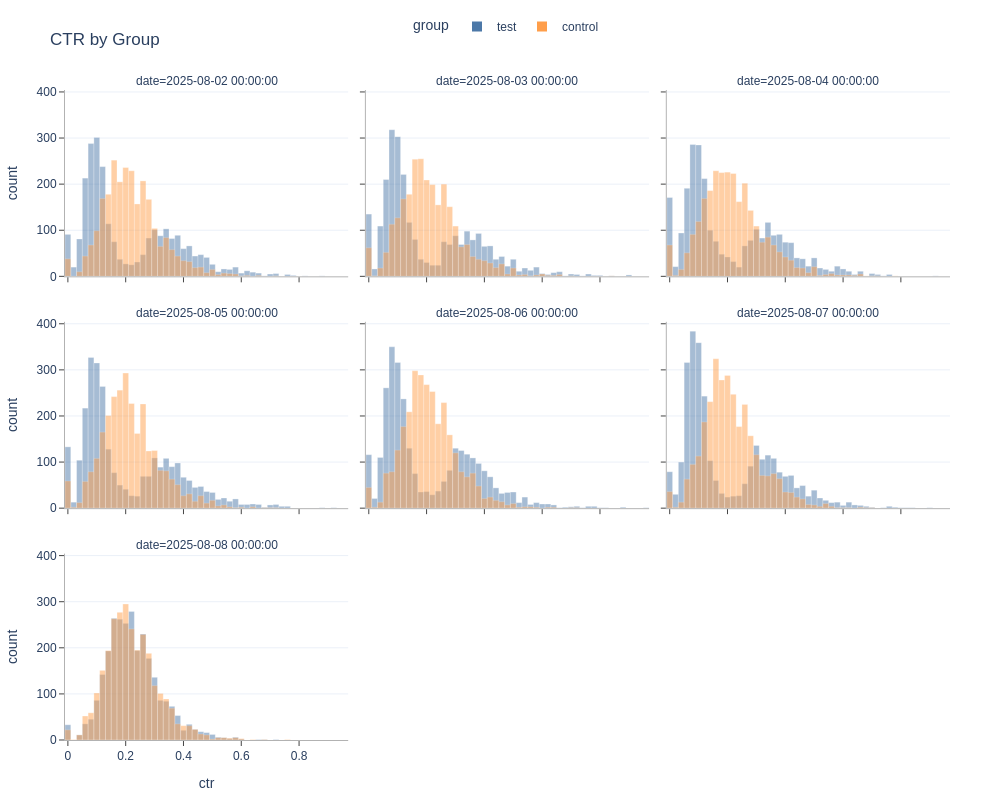

In [75]:
px.histogram(
    df_daily
    , x='ctr'
    , color='group'
    , facet_col='date'
    , facet_col_wrap=3
    , barmode='overlay'
    , nbins=50
    , title='CTR by Group'
    , width=1000
    , height=800
)

**Observations:**

- Bimodality appears every day except the last day.

### Likes and Views Segmentation

Let's categorize likes and views and examine the distribution between segments.

In [76]:
df['views_segment'] = df.groupby('group', observed=True)['views'].transform(lambda x: pd.qcut(x, 3, ['low', 'medium', 'high']))
df['likes_segment'] = df.groupby('group', observed=True)['likes'].transform(lambda x: pd.qcut(x, 3, ['low', 'medium', 'high']))
df['views_likes_segment'] = df['views_segment'].astype(str) + '-' + df['likes_segment'].astype(str)

Let's look at segment combinations.

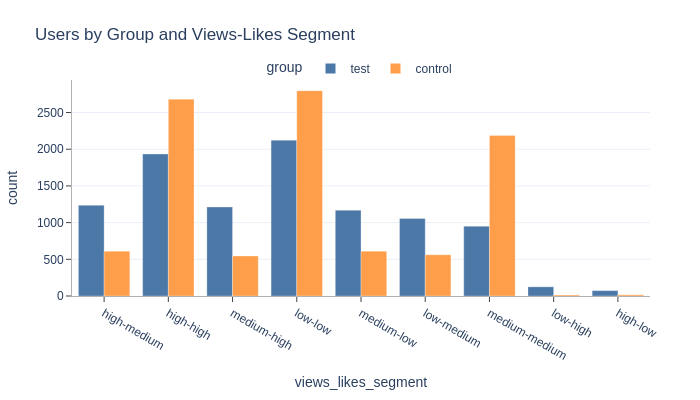

In [77]:
px.histogram(
    df
    , x='views_likes_segment'
    , color='group'
    , barmode='group'
    , width=700
    , title='Users by Group and Views-Likes Segment'
)

**Observations:**

- In the control group:
    - The most common are identical combinations. That is, those who viewed a lot and liked a lot, viewed moderately and liked moderately, viewed little and liked little.
    - This appears to be logical behavior. The number of likes and views is logically connected.
    - At the same time, segments where users viewed little but liked a lot, or viewed a lot but liked little, are small. This is also logical.
- In the test group:
    - The distribution differs from the control group.
    - Segments containing "medium" are clearly more represented than in the control group.
    - Specifically, the high-medium, medium-high, low-medium, and medium-low segments.
    - The medium-medium segment decreased the most.

Let's look at the segments separately.

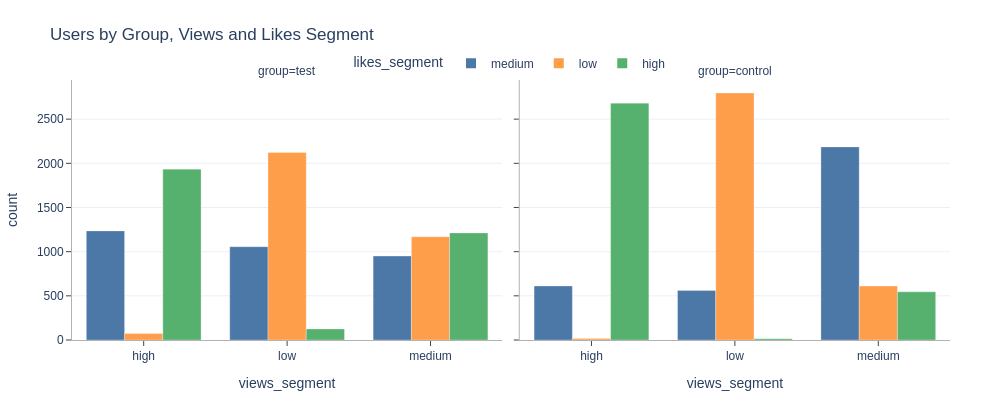

In [78]:
px.histogram(
    df
    , x='views_segment'
    , color='likes_segment'
    , facet_col='group'
    , barmode='group'
    , width=1000
    , title='Users by Group, Views and Likes Segment'
)

**Observations:**

- In the control group, each segment dominates its own category. This appears to be logical behavior.
- In the test group, the medium segment is also more represented than in the control group.

Let's examine CTR across segment combinations.

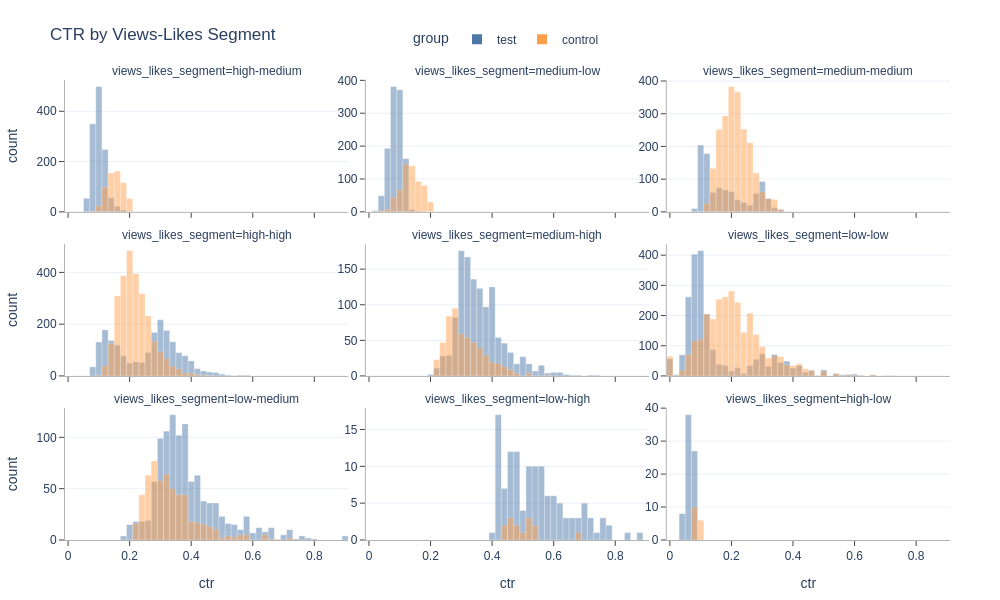

In [79]:
px.histogram(
    df
    , x='ctr'
    , facet_col='views_likes_segment'
    , color='group'
    , facet_col_wrap=3
    , barmode='overlay'
    , nbins=50
    , width=1000
    , height=600
    , title='CTR by Views-Likes Segment'
).update_yaxes(matches=None, showticklabels=True)

**Observations:**

- In the test group, signs of bimodality appear in the low-low and high-high segments. Also, in these segments, there is clearly less CTR around 20%, unlike the control group.
- 4 segments in the test group (high-medium, medium-high, low-medium, medium-low) are shifted relative to the control group:
    - "Viewed a lot and liked moderately" and "Viewed moderately and liked little" form the left mode with CTR ~10%.
    - "Viewed moderately and liked a lot" and "Viewed little and liked moderately" form the right mode with CTR ~30%.
- As a result, polarization is clearly noticeable.

### Metric Interactions

**At the User Level**

Let's examine how metrics interact at the level of individual users.

Let's look at likes and views.

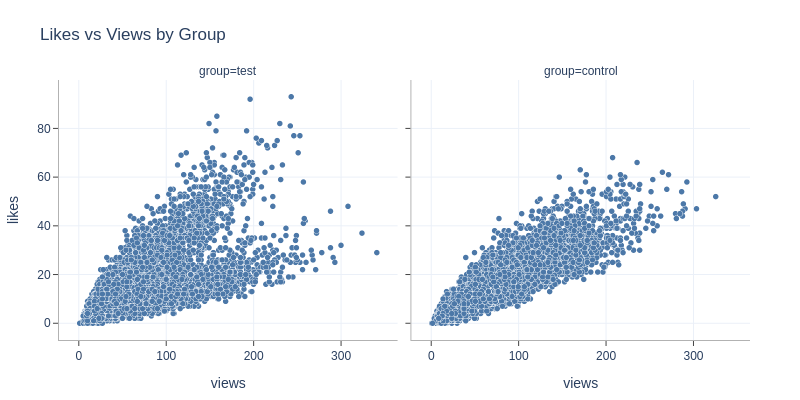

In [80]:
px.scatter(
    df
    , x ='views'
    , y = 'likes'
    , facet_col='group'
    , width=800
    , title='Likes vs Views by Group'
)

**Observations:**

- In the control group, the distribution is more clustered.
- In the test group, a splitting is noticeable. This is also a sign of polarization.

## Statistical Analysis

Testing hypothesis 1 is not meaningful because:

- The analysis revealed anomalies (bimodality) in the test group, indicating a high probability of technical problems during the experiment.
- The main argument is that bimodality was present for the first 6 days but disappeared on the last day.
- If the impact on the test group was consistent for all 7 days, this could not have happened. This is a clear signal of technical issues.

# Analysis of A/B Test Results for Hypothesis 2

A/B test ran from `2025-08-02` to `2025-08-08`

## Data Loading

Get the data.

In [81]:
%%sql df <<
WITH user_first_visit AS (
    SELECT 
        user_id
        , min(toDate(time)) as first_date
    FROM 
        feed_actions
    GROUP BY 
        user_id
)
, exp_data as (
    SELECT 
        multiIf(
            exp_group = 0, 'control'
            , exp_group = 3, 'test'
            , 'unknown'
        ) as group
        , argMax(multiIf(
            gender = 1, 'female'
            , gender = 0, 'male'
            , 'unknown'
        ), time) as gender
        , argMax(multiIf(
            age < 25, '<25'
            , age between 25 and 40, '25-40'
            , age between 41 and 55, '41-55' 
            , age >= 56, '56+'
            , 'unknown'
        ), time) as age_group      
        , argMax(source, time) as source
        , argMax(os, time) as os
        , argMax(country, time) as country
        , argMax(city, time) as city
        , user_id
        , uniq(post_id) as posts
        , countIf(action = 'like') as likes
        , countIf(action = 'view') as views
        , ifNull(likes / nullIf(views, 0), 0) as ctr
        , uniq(toDate(time)) as days
    FROM
        feed_actions
    WHERE 
        toDate(time) BETWEEN '2025-08-02' and '2025-08-08'
        and exp_group in (0, 3)
    GROUP BY
        group
        , user_id
)
SELECT
        ed.*
        , if(ufv.first_date >= '2025-08-02', 'new', 'existing') as user_status
FROM
    exp_data ed
    LEFT JOIN user_first_visit ufv ON ed.user_id = ufv.user_id

Returning data to local variable df


In [82]:
%%sql df_daily <<
SELECT 
    toDate(time) as date
    , user_id
    , uniq(post_id) as posts
    , countIf(action = 'like') as likes
    , countIf(action = 'view') as views
    , ifNull(likes / nullIf(views, 0), 0) as ctr    
    , multiIf(
        exp_group = 0, 'control'
        , exp_group = 3, 'test'
        , 'unknown'
    ) as group
    , argMax(multiIf(
        gender = 1, 'female'
        , gender = 0, 'male'
        , 'unknown'
    ), time) as gender
    , argMax(multiIf(
        age < 25, '<25'
        , age between 25 and 40, '25-40'
        , age between 41 and 55, '41-55' 
        , age >= 56, '56+'
        , 'unknown'
    ), time) as age_group    
    , argMax(source, time) as source
    , argMax(os, time) as os
    , argMax(country, time) as country
    , argMax(city, time) as city
FROM
    feed_actions
WHERE 
    toDate(time) BETWEEN '2025-08-02' and '2025-08-08'
    and exp_group in (0, 3)
GROUP BY
    date
    , user_id
    , group
ORDER BY
    date    

Returning data to local variable df_daily


Convert the date to datetime.

In [83]:
df_daily['date'] = pd.to_datetime(df_daily['date'])

In [84]:
df.head(3)

,group,gender,age_group,source,os,country,city,user_id,posts,likes,views,ctr,days,user_status
0,control,male,<25,ads,iOS,Russia,Belgorod,23121,165,38,229,0.17,4,existing
1,control,female,25-40,ads,iOS,Russia,Desnogorsk,12756,17,1,17,0.06,1,existing
2,test,male,25-40,organic,iOS,Russia,Kushva,133117,36,9,43,0.21,1,new


In [85]:
df_daily.head(3)

,date,user_id,posts,likes,views,ctr,group,gender,age_group,source,os,country,city
0,2025-08-02,28055,29,9,34,0.26,control,male,<25,ads,Android,Russia,Kolpino
1,2025-08-02,121661,29,10,29,0.34,control,female,25-40,organic,iOS,Russia,Novosibirsk
2,2025-08-02,317,19,5,19,0.26,control,male,<25,ads,Android,Russia,Novosibirsk


In [86]:
df.dtypes

group           object
gender          object
age_group       object
source          object
os              object
country         object
city            object
user_id          int64
posts            int64
likes            int64
views            int64
ctr            float64
days             int64
user_status     object
dtype: object

In [87]:
df_daily.dtypes

date         datetime64[ns]
user_id               int64
posts                 int64
likes                 int64
views                 int64
ctr                 float64
group                object
gender               object
age_group            object
source               object
os                   object
country              object
city                 object
dtype: object

Replace the data type for dimensions with categorical.

In [88]:
df['group'] = df['group'].astype('category')
df['gender'] = df['gender'].astype('category')
df['age_group'] = df['age_group'].astype('category')
df['source'] = df['source'].astype('category')
df['os'] = df['os'].astype('category')
df['country'] = df['country'].astype('category')
df['city'] = df['city'].astype('category')
df['user_status'] = df['user_status'].astype('category')

In [89]:
df_daily['group'] = df_daily['group'].astype('category')
df_daily['gender'] = df_daily['gender'].astype('category')
df_daily['age_group'] = df_daily['age_group'].astype('category')
df_daily['source'] = df_daily['source'].astype('category')
df_daily['os'] = df_daily['os'].astype('category')
df_daily['country'] = df_daily['country'].astype('category')
df_daily['city'] = df_daily['city'].astype('category')

## Data Exploration

Explore DataFrame.

In [90]:
info(df)

Full duplicates: 0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
group,19922,2,test,10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,19922,2,female,11039,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_group,19922,4,<25,10506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,19922,2,organic,10702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
os,19922,2,Android,12924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,19922,11,Russia,17479,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,19922,2125,Moscow,2652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,"19,922.00",NaN,NaN,NaN,"76,111.20","53,180.56",200.00,"22,215.50","109,629.00","126,483.50","140,806.00"
posts,"19,922.00",NaN,NaN,NaN,52.33,30.11,1.00,29.00,47.00,71.00,198.00
likes,"19,922.00",NaN,NaN,NaN,14.66,10.35,0.00,7.00,12.00,20.00,89.00


,group,gender,age_group,source,os,country,city,user_id,posts,likes,views,ctr,days,user_status
Dupl,19920,19920,19918,19920,19920,19911,17797,0,19739,19843,19638,17661,19915,19920


,group,gender,age_group,source,os,country,city,user_id,posts,likes,views,ctr,days,user_status
Miss,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,user_id,posts,likes,views,ctr,days
Zeros,0,0,101,0,101,0


,user_id,posts,likes,views,ctr,days
Negs,0,0,0,0,0,0


**Observations:**

- Everything is fine.
- Null values are present where they are acceptable.
- There are no duplicates in user_id.
- 2 groups.
- The minimum value in views is not 0.
- There are no negative values.

### Checking the Correctness of the Splitting

Check the correctness of splitting.

In [91]:
check_split_correctness(df)

=== SPLITTING CORRECTNESS CHECK ===

1. USER UNIQUENESS CHECK:
Checking that there are no users present in both groups simultaneously.
✅ SUCCESS: No users found in both groups simultaneously.
   Number of users in both groups: 0


2. GROUP SIZE BALANCE CHECK:

- H0: The number of users in test and control groups is equal
- H1: The number of users in test and control groups is not equal

We choose a significance level of 0.05.
We use the chi-square goodness-of-fit test.
Observed counts: {'test': np.int64(10002), 'control': np.int64(9920)}
Expected counts (equal distribution): [np.float64(9961.0), np.float64(9961.0)]
Chi-square statistic: 0.3375
P-value: 0.5613
Percentage difference: 0.41%
✅ FAIL TO REJECT H0: The number of users in test and control groups is equal.
   Group sizes are balanced statistically.

SUMMARY:
✅ ALL CHECKS PASSED: Splitting system appears to be working correctly.


### User Distribution

Let's examine how users are distributed across dimensions.

**By Test Group**

Let's check how users are distributed across groups.

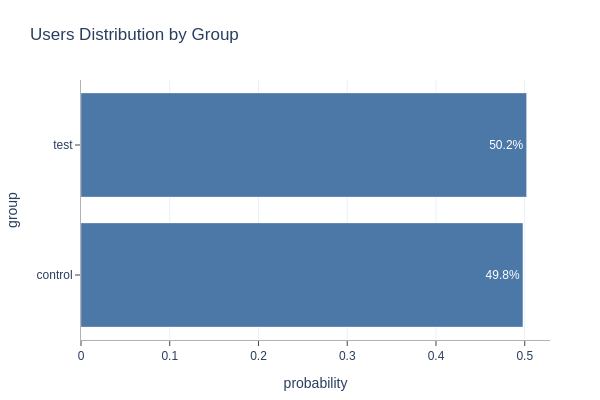

In [92]:
px.histogram(
    df
    , y='group'
    , histnorm='probability'
    , text_auto='.1%'
    , title='Users Distribution by Group'
)

**Observations:**

- Approximately equal distribution across groups.

**By User Status (New or Not)**

Let's check how users are distributed by new user status.

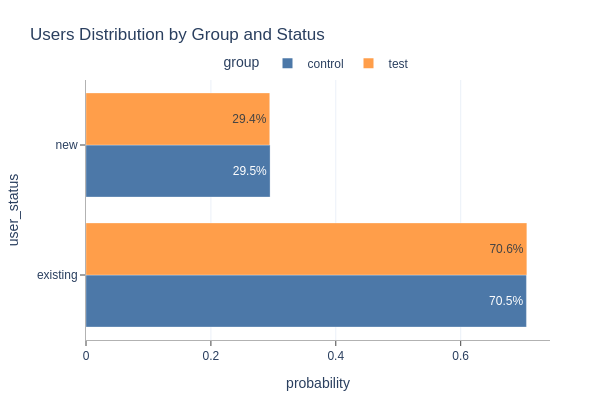

In [93]:
px.histogram(
    df
    , y='user_status'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Status'
)

**Observations:**

- Both groups have about 29% new users (first appeared during the test).
- The ratio between groups is approximately the same.

**By Gender**

Let's check how users are distributed by gender.

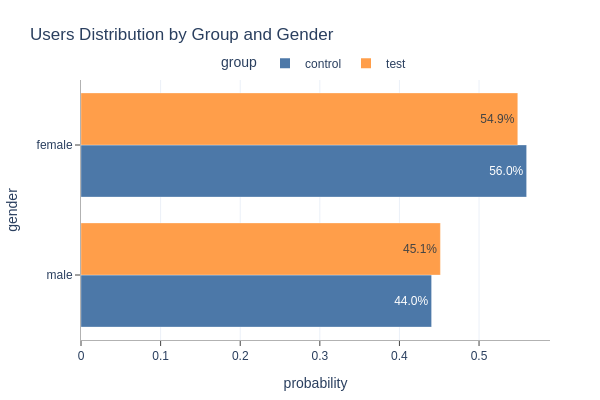

In [94]:
px.histogram(
    df
    , y='gender'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Gender'
)

**Observations:**

- There are more women in both groups.
- The ratio between groups is approximately the same.

**By Age Group**

Let's check how users are distributed across age groups.

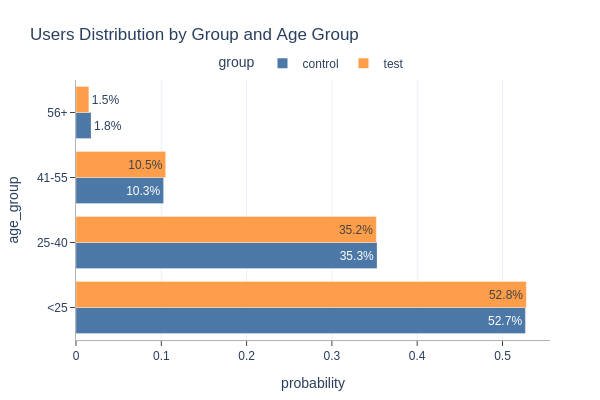

In [95]:
px.histogram(
    df
    , y='age_group'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Age Group'
)

**Observations:**

- Users under 25 are the largest group in both groups.
- 25-40 years old is the second largest.
- The ratio in each age category is approximately the same between groups.

**By OS**

Let's check how users are distributed by OS.

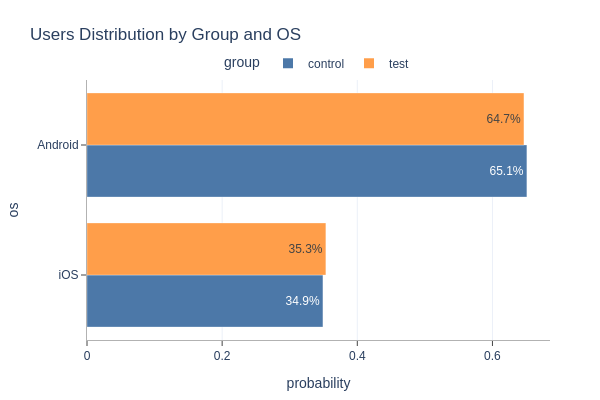

In [96]:
px.histogram(
    df
    , y='os'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and OS'
)

**Observations:**

- There are more Android users in both groups.
- The distribution between groups is approximately the same.


**By Source**

Let's check how users are distributed by traffic source.

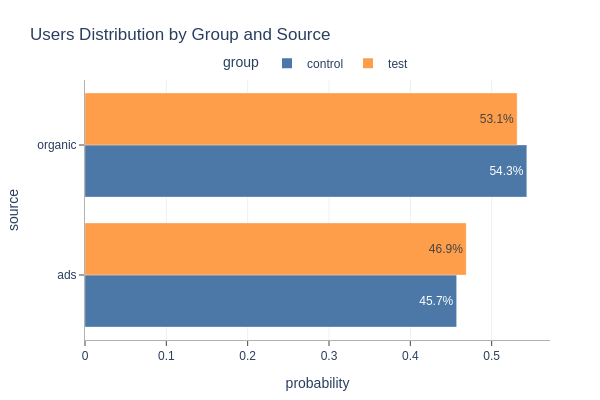

In [97]:
px.histogram(
    df
    , y='source'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Source'
)

**Observations:**

- Organic traffic is slightly higher than paid traffic.
- The distribution between groups is approximately the same.


**By Country**

Let's check how users are distributed by country.

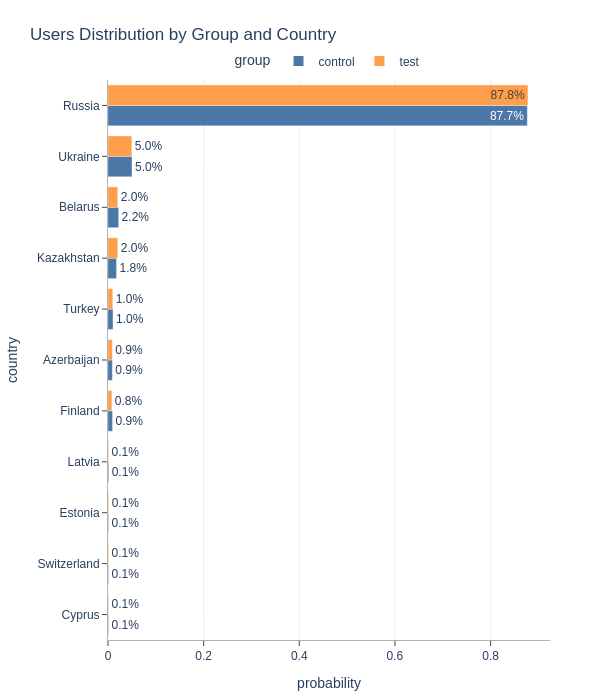

In [98]:
px.histogram(
    df
    , y='country'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Country'
    , height=700
).update_layout(
    legend_y=1.06
    , yaxis={'categoryorder': 'total ascending'}
)

**Observations:**

- Most users are from Russia.
- The distribution between groups is approximately the same.


**By Top Cities**

Let's check how users are distributed across top cities.

In [99]:
top_cities = df['city'].value_counts().nlargest(10).index

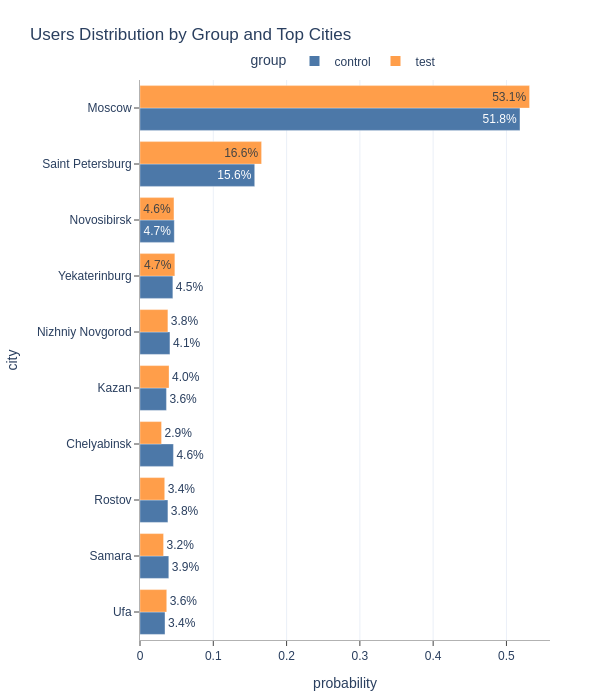

In [100]:
px.histogram(
    df[df['city'].isin(top_cities)]
    , y='city'
    , color='group'
    , histnorm='probability'
    , barmode='group'
    , text_auto='.1%'
    , title='Users Distribution by Group and Top Cities'
    , height=700
).update_layout(
    legend_y=1.06
    , yaxis={'categoryorder': 'total ascending'}
)

**Observations:**

- Most users are from Moscow and St. Petersburg.
- The distribution between groups is similar.

### Distribution of Post Count

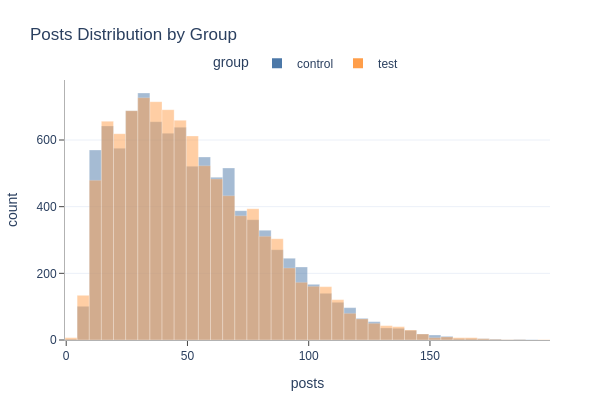

In [101]:
px.histogram(
    df
    , x='posts'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='Posts Distribution by Group'
)

**Observations:**

- Nothing unusual.

### Distribution of Likes Count

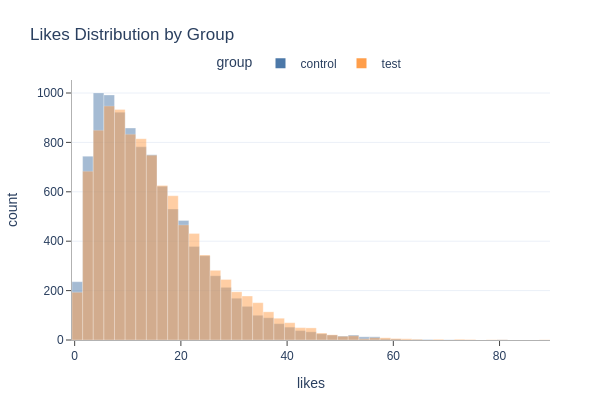

In [102]:
px.histogram(
    df
    , x='likes'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='Likes Distribution by Group'
)

**Observations:**

- Nothing unusual.

### Distribution of Views

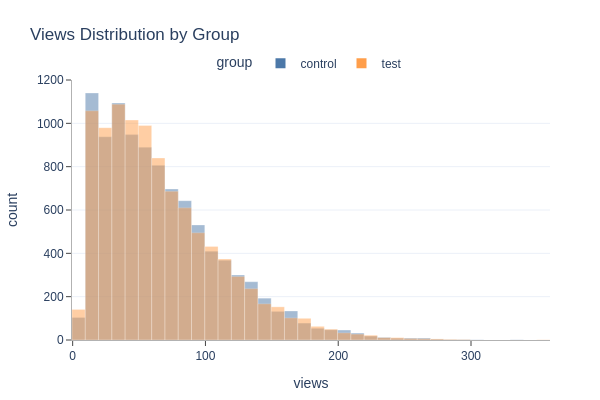

In [103]:
px.histogram(
    df
    , x='views'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='Views Distribution by Group'
)

**Observations:**

- Nothing unusual.

### Distribution of CTR

Let's examine how CTR is distributed across groups.

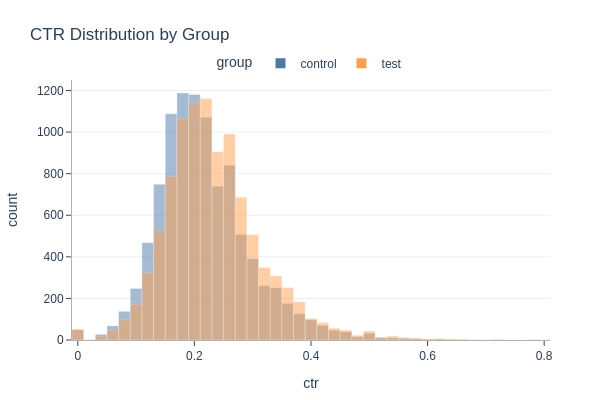

In [104]:
px.histogram(
    df
    , x='ctr'
    , color='group'
    , barmode='overlay'
    , nbins=50
    , title='CTR Distribution by Group'
)

**Observations:**

- Distributions resemble normal.
- The distribution in the test group is slightly shifted to the right.
- No bimodality is observed.

### CTR Distribution by Day

Let's examine how CTR was distributed each day.

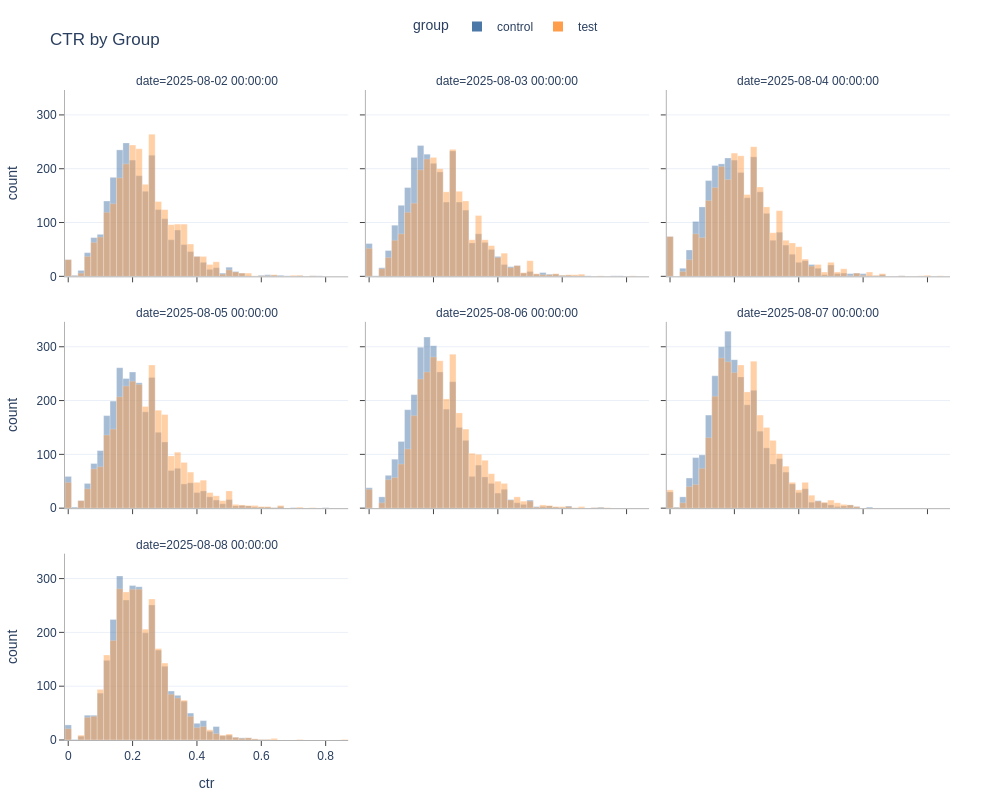

In [105]:
px.histogram(
    df_daily
    , x='ctr'
    , color='group'
    , facet_col='date'
    , facet_col_wrap=3
    , barmode='overlay'
    , nbins=50
    , title='CTR by Group'
    , width=1000
    , height=800
)

**Observations:**

- No bimodality is observed on any day.

### Metric Interactions

**At the User Level**

Let's examine how metrics interact at the level of individual users.

Let's look at likes and views.

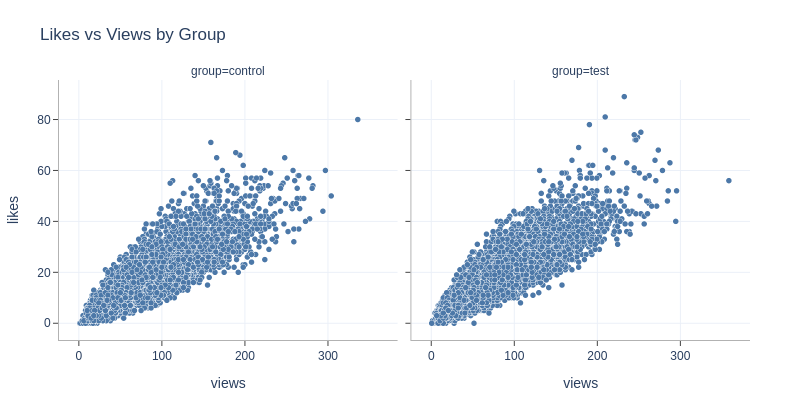

In [106]:
px.scatter(
    df
    , x ='views'
    , y = 'likes'
    , facet_col='group'
    , width=800
    , title='Likes vs Views by Group'
)

**Observations:**

- No signs of bimodality are observed.

Since no bimodality is detected, repeating a more detailed segment analysis is unnecessary.

## Statistical Analysis

To ensure our test controls the Type I error, let's run an A/A test simulation. For this:

- Shuffle the groups and randomly split them into 2 groups.
- Apply the delta method and save the p-value and the indicator of whether we reject the null hypothesis.
- Set alpha to 0.05.
- Repeat 10,000 times.
- Calculate the percentage of cases where we rejected the null hypothesis. This will be our Type I error rate.
- Also, plot the p-values.

In [107]:
alpha = 0.05
n_sim = 10_000
indexes = df_linearized.index.values
control_len = len(df[df['group'] == 'control'])
pvals = []
for _ in tqdm(range(n_sim)):    
    np.random.shuffle(indexes)
    simulated_control_idx = indexes[:control_len]
    simulated_test_idx = indexes[control_len:]
    # Create a temporary DataFrame with new groups
    temp_df = df.copy()
    temp_df['simulated_group'] = 'control'
    temp_df.loc[simulated_test_idx, 'simulated_group'] = 'test'    
    # We recalculate the linearization based on the new “control”
    simulated_global_ctr = (
        temp_df[temp_df['simulated_group'] == 'control']['likes'].sum() 
        / temp_df[temp_df['simulated_group'] == 'control']['views'].sum()
    )
    temp_df['simulated_linearized'] = (
        temp_df['likes'] - temp_df['views'] * simulated_global_ctr
    )    
    # T-test on the recalculated linearized metric
    control_linearized = temp_df[temp_df['simulated_group'] == 'control']['simulated_linearized']
    test_linearized = temp_df[temp_df['simulated_group'] == 'test']['simulated_linearized']
    
    pval = pg_ttest(control_linearized, test_linearized)
    pvals.append(pval)    

false_positive_rate = (np.array(pvals) < alpha).mean() 

100%|██████████| 10000/10000 [04:39<00:00, 35.74it/s]


False positive rate = 3.5%


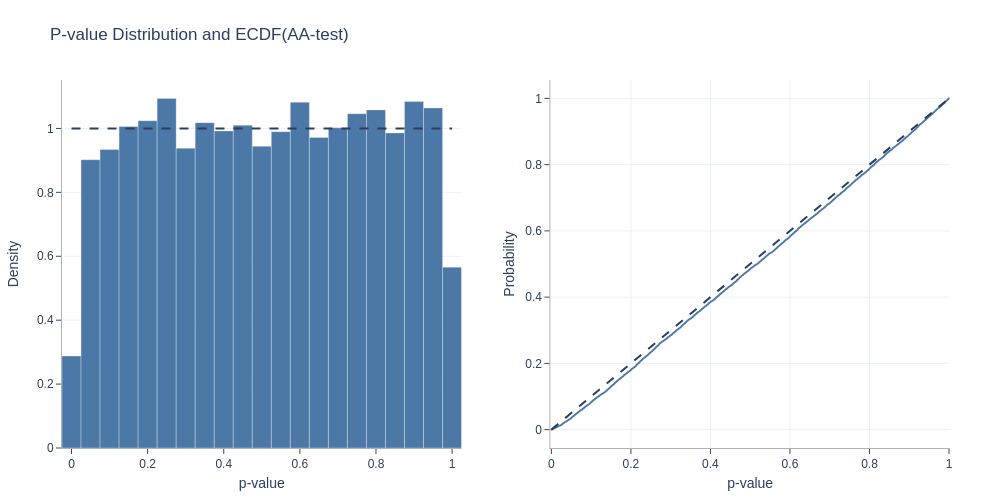

In [108]:
print(f'False positive rate = {false_positive_rate:.1%}')
plot_pvalue_ecdf(pvals, 'P-value Distribution and ECDF(AA-test)')

**Observations:**

- FPR is close to 5%. As it should be.
- The p-value distribution is close to uniform.
- The ECDF slightly deviates from the 45-degree line.
- The A/A test simulation showed that we control the Type I error rate on our data when using the delta method.

Conduct the test.

Linearized metric created using global CTR from control group
Global CTR: 0.2098
Difference in Global CTR (test - control): 0.0164


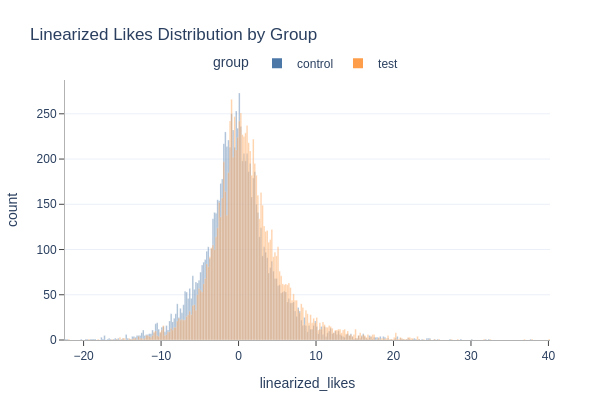

Formulate hypotheses:
- H0: Mean value of the linearized metric in control and test groups are equal
- H1: Mean value of the linearized metric in control and test groups are not equal

Significance level: 0.05

Variance homogeneity test (Levene's test):


,W,pval,equal_var
levene,0.14,0.71,True



Variances are equal (p-value ≥ 0.05) - using standard t-test without correction

Difference in means (test - control): 1.0948

T-test results:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,16.19,19920,two-sided,0.00,"[0.96, 1.23]",0.23,4.882e+54,NaN



Conclusion:
REJECT H0: p-value (0.0000) < 0.05 - Significant difference detected


In [109]:
ttest_linearized(df)

**Observations:**

- p-value is below the significance level, therefore we reject the null hypothesis.
- According to the t-test on linearized metric, there is a statistically significant difference in CTR between the groups.
- In the test group, CTR is above than in the control group by 0.0164.

Let's calculate the power of our test assuming the difference truly exists, using the Monte Carlo method.

Calculate linearized metrics.

In [110]:
df_linearized = df[['group', 'views', 'likes']].copy()

In [111]:
global_ctr = (
    df_linearized[df_linearized['group'] == 'control']['likes'].sum() 
    / df_linearized[df_linearized['group'] == 'control']['views'].sum()
)
df_linearized['linearized_likes'] = df_linearized['likes'] - df_linearized['views'] * global_ctr
linearized_likes_control = df_linearized[df_linearized['group'] == 'control'].linearized_likes
linearized_likes_test = df_linearized[df_linearized['group'] == 'test'].linearized_likes

Calculate the power of T-test on the linearized metric.

In [112]:
power, results, effect_sizes, p_values = monte_carlo_power(
    data_a=linearized_likes_control
    , data_b=linearized_likes_test
    , test_func=pg_ttest
    , alpha=0.05
    , n_sim=10_000
    , effect_size=mde_linearized
)
display(results)

100%|██████████| 10000/10000 [01:18<00:00, 127.25it/s]


{'power': 1.0,
 'effect_size': np.float64(0.7036443323727185),
 'mean_effect': np.float64(1.7985948489653911),
 'effect_std': np.float64(0.06710130747402315),
 'mean_pvalue': np.float64(3.833305092065971e-114),
 'n_sim': 10000,
 'sample_size_a': 9920,
 'sample_size_b': 10002}

**Observations:**

- The power calculated by the Monte Carlo method is almost 100%.

For interest, let's also see how the p-value changed over days.
To do this, we will calculate cumulative likes and views for each user.

In [113]:
daily_pvalue = pd.DataFrame(columns=['pvalue', 'date']).set_index('date')

In [114]:
for date in df_daily.date.unique():
    # Get cumulative data up to current date
    control = (
        df_daily[(df_daily.group == 'control') & (df_daily.date <= date)]
        .groupby('user_id')[['likes', 'views']].sum()
    )
    test = (
        df_daily[(df_daily.group == 'test') & (df_daily.date <= date)]    
        .groupby('user_id')[['likes', 'views']].sum()
    )
    
    # Skip if not enough data
    if len(control) < 2 or len(test) < 2:
        daily_pvalue.loc[date, 'pvalue'] = np.nan
        continue
    
    # Calculate linearized metric for current cumulative data
    global_ctr = control['likes'].sum() / control['views'].sum()
    
    control_linearized = control['likes'] - control['views'] * global_ctr
    test_linearized = test['likes'] - test['views'] * global_ctr
    
    # Perform t-test on linearized metric
    pvalue = pg_ttest(test_linearized, control_linearized)
    
    daily_pvalue.loc[date, 'pvalue'] = pvalue

Let's plot the graph.

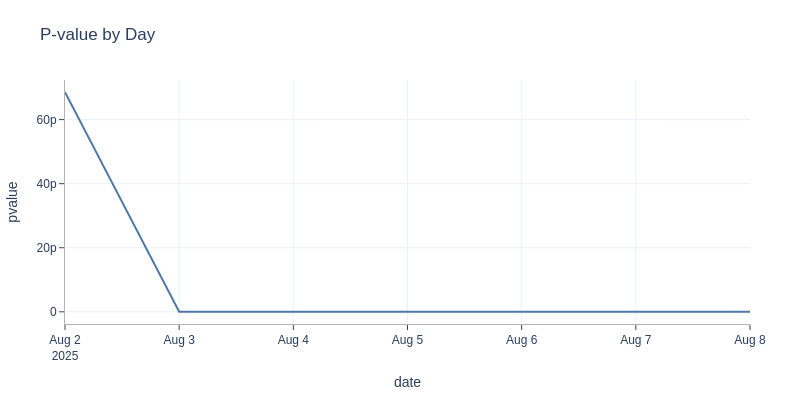

In [115]:
px.line(
    daily_pvalue.reset_index()
    , x='date'
    , y='pvalue'
    , title='P-value by Day'
    , width=800
)

# Conclusion

## Decision on Rolling Out the New Algorithm to All Users

### Hypothesis 1: "Similar to Liked Posts" Algorithm
**Decision:** Do not roll out this algorithm
- The analysis revealed anomalies (bimodality) in the test group, indicating a high probability of technical problems during the experiment
- Bimodality was present for the first 6 days but disappeared on the last day, suggesting inconsistent treatment application
- The presence of two distinct modes (10% and 30% CTR) vs historical 20% indicates potential system malfunctions

### Hypothesis 2: "Posts Liked by Similar Users" Algorithm  
**Decision:** Recommend limited rollout
- No bimodality or technical anomalies observed in the test group
- T-test on linearized metric shows statistically significant difference (p < 0.05)
- CTR in test group is 0.0164 percentage points higher than control group
- Distribution patterns appear normal across all days and dimensions

## Detailed A/B Test Results

### Technical Issues in Hypothesis 1

- After examining the data, it was discovered that the test group has a bimodal distribution.
- This indicates the possible presence of two different populations or technical problems.
- The control group has a unimodal distribution.
- The mean values differ only slightly.
- The trough of the test group is located at the level of the control group's mode.
- Considering all this, performing hypothesis testing on the mean CTRs is considered incorrect. Comparing measures of central tendency would be generally invalid.
- We would essentially be comparing the "average hospital temperature" in the test group with the mean in the control group.
- It is necessary to identify the causes of the bimodality, eliminate them, and conduct a new experiment.
- Furthermore, the modes of the test group (10% and 30%) indicate that:
    - A significant portion of the audience is very dissatisfied with the new news recommendation mechanism (CTR 10% vs. historical 20%).
    - A significant portion of the audience is very satisfied with the new news recommendation mechanism (CTR 30% vs. historical 20%).
- The suspiciously strong deviations in CTR (two modes in the test group) from historical levels may indicate that:
    - Either something broke in the test group during the experiment,
    - Or some users really liked it while others really disliked it, which is less likely.
- One could accept that users started liking posts less if they were shown irrelevant posts.
- But for CTR to increase from 20% to 30% is highly unlikely. It looks more like a bug.
- The hypothesis of technical problems is also supported by the last day, when the bimodality disappeared.
    - If our new recommendation system factor was applied consistently to the test group for all 7 days, this should not have happened.

After categorizing likes and views and combining segments into combinations, it was discovered:

- The distribution across segments in the test group differs from the control group.
- Segments containing "medium" are clearly more represented than in the control group (high-medium, medium-high, low-medium, and medium-low segments).
- The medium-medium segment decreased the most.
- Signs of bimodality appear in the low-low and high-high segments. Also, in these segments, CTR around 20% is clearly less frequent compared to the control group.
- As a result, 4 segments (high-medium, medium-high, low-medium, medium-low) strongly influence the bimodality.
    - "Viewed a lot and liked moderately" and "Viewed moderately and liked little" form the left mode with CTR ~10%.
    - "Viewed moderately and liked a lot" and "Viewed little and liked moderately" form the right mode with CTR ~30%.
- And the medium-medium segment became smaller.
- Clear signs of polarization are present.

### Valid Results in Hypothesis 2

- Control and test groups show comparable user distribution across all dimensions
- Unimodal CTR distributions in both groups indicate consistent treatment application  
- Statistical testing is valid and reliable for this hypothesis
- The observed CTR improvement of 0.0164 represents a meaningful engagement increase

# Recommendations

### For Hypothesis 1:
- Investigate the causes of bimodality in the test group.
    - It strongly resembles technical problems, given the presence of two modes around 10% and 30%.
    - Meanwhile, the historical CTR is around 20%.
    - This is a large deviation that is unlikely to occur under normal conditions.
- Take into account that bimodality was absent on the last test day. This might help in identifying the problem.

### For Hypothesis 2:
- Gradually roll out the "Posts Liked by Similar Users" algorithm to increasingly larger audience segments
- Maintain close monitoring of key metrics and user behavior throughout the rollout process

# Supplement 1. Additional Tests

- Let's compare different statistical tests on our data for practice purposes.
- We will conduct tests for Hypothesis 1 to study how bimodality affects different statistical methods.
- Note that testing one hypothesis with multiple tests increases the Type I error rate.
- However, since we won't make decisions based on these tests, multiple testing correction is not required.
- This analysis is for research and educational purposes only.

Let's create auxiliary variables.

In [116]:
df = df_for_supplement
df['smoothed_ctr'] = (
    df.groupby('group', observed=True)
    .apply(apply_smoothed_ctr, include_groups=False)
    .reset_index(level=0, drop=True)
)
df_control = df[df.group == 'control']
df_test = df[df.group == 'test']
ctr_control = df_control.ctr
ctr_test = df_test.ctr
smoothed_ctr_control = df_control['smoothed_ctr']
smoothed_ctr_test = df_test['smoothed_ctr']
observed_diff = df_test['likes'].sum() / df_test['views'].sum() - df_control['likes'].sum() / df_control['views'].sum()

## Variance Equality Test

Let's test variance equality for regular and smoothed CTR.

**Regular CTR**

Test variance equality using Levene's test.

- H0: Variances in control and test groups are equal
- H1: Variances in control and test groups are not equal

Set significance level to 0.05.

In [117]:
pg.homoscedasticity(df, dv='ctr', group='group')

,W,pval,equal_var
levene,"2,757.79",0.00,False


**Result:**

- At significance level 0.05, we reject the null hypothesis of equal variances since p-value is less than the significance level.

**Smoothed CTR**

Test variance equality using Levene's test.

- H0: Variances in control and test groups are equal
- H1: Variances in control and test groups are not equal

Set significance level to 0.05.

In [118]:
pg.homoscedasticity(df, dv='smoothed_ctr', group='group')

,W,pval,equal_var
levene,"3,120.78",0.00,False


**Result:**

- At significance level 0.05, we reject the null hypothesis of equal variances since p-value is less than the significance level.

## T-test

- Although the t-test is quite robust, and we don't have strong asymmetry or outliers, the bimodality ruins everything.
- The t-test cannot be applied with obvious bimodality since we essentially don't have one measure of central tendency.
- Bimodality indicates the presence of not one, but two underlying populations.
- As a result, the t-test compares the "average hospital temperature"
- Moreover, we would be comparing user-level CTR, not global CTR

Formulate null and alternative hypotheses.
- H0: Mean user-level CTR in control and test groups are equal
- H1: Mean user-level CTR in control and test groups are not equal

Since variances are not equal, we will use Welch's test.

Let's examine the difference in mean CTR values.

In [119]:
ctr_test.mean() - ctr_control.mean()

np.float64(-0.0006723047962903239)

Set significance level to 0.05.

In [120]:
pg.ttest(ctr_test, ctr_control, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.41,"15,811.23",two-sided,0.69,"[-0.0, 0.0]",0.01,0.017,0.07


**Observations:**

- p-value is higher than the significance level, therefore there are no grounds to reject the null hypothesis.
- According to Welch's test, there are no statistically significant differences in CTR between groups.
- Note that pingouin shows very low power.

## T-test on Smoothed CTR

- Smoothing doesn't solve the problems of the regular t-test.
- In this case, it's better not to perform a t-test on smoothed CTR.

Let's examine the distribution.

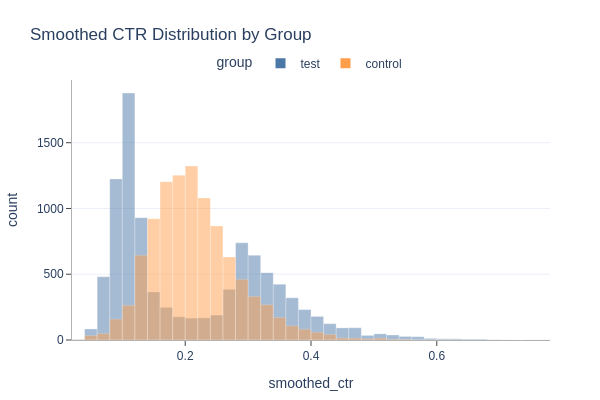

In [121]:
px.histogram(
    df
    , x='smoothed_ctr'
    , color='group'
    , nbins=50
    , barmode='overlay'
    , title='Smoothed CTR Distribution by Group'
)

Formulate null and alternative hypotheses.

- H0: Mean smoothed user-level CTR in control and test groups are equal
- H1: Mean smoothed user-level CTR in control and test groups are not equal

Since variances are not equal, we will use Welch's test.

Let's examine the difference in mean smoothed CTR values.

In [122]:
smoothed_ctr_test.mean() - smoothed_ctr_control.mean()

np.float64(-0.002771774229591073)

Set significance level to 0.05.

In [123]:
pg.ttest(smoothed_ctr_test, smoothed_ctr_control, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.95,"15,580.63",two-sided,0.05,"[-0.01, 0.0]",0.03,0.106,0.50


**Observations:**

- p-value is higher than or equal to the significance level, therefore there are no grounds to reject the null hypothesis.
- According to Welch's test, there are no statistically significant differences in smoothed CTR between groups.
- Smoothing increased the t-test power and decreased the p-value.
- Most likely, smoothing reduced variance in each group, consequently increasing power and decreasing p-value.
- The t-test is highly sensitive to variance - the smaller the variance, the more powerful it is.

## Mann-Whitney Test

- The Mann-Whitney test should not be used to compare measures of central tendency.
- Especially with different variances, as it becomes unpredictable.
    - This is easily verified by simulating two normal distributions with the same mean but different variances.
- This is logical since it compares distributions, not means or medians. To be more precise, it tests for statistical dominance of one sample over another.
- The exception is when one sample is obtained by shifting the other, they have similar distributions, and variances are equal.
    - In this case, it works well and will show if one sample statistically dominates the other.
    - But in practice, this is a rare case.

Formulate null and alternative hypotheses.
- H0: The probability that a randomly selected user-level CTR value from the test group will exceed a randomly selected user-level CTR value from the control group equals the probability of the opposite outcome.
- H1: The probability that a randomly selected user-level CTR value from the test group will exceed a randomly selected user-level CTR value from the control group is not equal to 0.5.

Set significance level to 0.05.

In [124]:
pg.mwu(ctr_test, ctr_control)

,U-val,alternative,p-val,RBC,CLES
MWU,"43,777,627.00",two-sided,0.00,-0.12,0.44


**Observations:**
- p-value is below the significance level, therefore there are grounds to reject the null hypothesis.
- According to the Mann-Whitney test, one of the CTR distributions statistically significantly dominates the other.
- This is logical since the test group has a bimodal distribution with a trough located at the peak of the control group.
- Mann-Whitney detected substantial differences in the distributions.
- However, this result provides little business value.

## Bootstrap on User-Level CTR

- Bimodality is not a problem for bootstrap. In this case, it can be applied.
- However, this doesn't change the fact that the mean will represent the "hospital temperature average" due to bimodality. But this is not a bootstrap problem.
- Bootstrap on user-level CTR with bimodality is better not to apply.

Formulate null and alternative hypotheses.
- H0: Mean user-level CTR in control and test groups are equal
- H1: Mean user-level CTR in control and test groups are not equal

Set significance level to 0.05 (95% confidence interval).

In [125]:
def statistic(x, y):
    return np.mean(x) - np.mean(y)
boot_res = stats.bootstrap(
    data=(ctr_test, ctr_control), 
    statistic=statistic,
    batch=1000
)
ci_low = boot_res.confidence_interval.low
ci_high = boot_res.confidence_interval.high
effect_size = pg.compute_effsize(ctr_test, ctr_control, eftype='cohen')
print(f"Difference in means (test - control): {statistic(ctr_test, ctr_control):.2f}")
print(f"95% confidence interval: [{ci_low:.2f}, {ci_high:.2f}]")
print(f'Effect size: {effect_size:.2f}')

Difference in means (test - control): -0.00
95% confidence interval: [-0.00, 0.00]
Effect size: -0.01


**Observations:**
- Zero falls within the 95% confidence interval, therefore there are no grounds to reject the null hypothesis.
- Bootstrap did not find statistically significant differences in CTR between groups.
- According to bootstrap, the true effect with 95% probability lies in the range from a small decrease to a small increase in CTR.
- There are no complaints about the bootstrap result. It did its job. It doesn't account for bimodality.

## Bootstrap of Global CTR

- This test should not have problems with bimodality.
- Disadvantages: computationally intensive on large data and inability to apply variance reduction methods.

Formulate null and alternative hypotheses.
- H0: Mean global CTR in control and test groups are equal
- H1: Mean global CTR in control and test groups are not equal

Set significance level to 0.05 (95% confidence interval).

Create a function for bootstrap.

In [126]:
def bootstrap_global_ctr_diff(
    likes_test, views_test
    , likes_control
    , views_control
    , n_bootstraps=10_000
    , confidence_level=0.95
    ):
    """Bootstrap for difference in global CTR"""
    n_test = len(likes_test)
    n_control = len(likes_control)
    
    # Array to store bootstrap statistics
    bs_diffs = np.zeros(n_bootstraps)
    
    for i in range(n_bootstraps):
        # Bootstrap for test group
        idx_test = np.random.choice(n_test, size=n_test, replace=True)
        likes_bs_test = likes_test[idx_test]
        views_bs_test = views_test[idx_test]
        ctr_bs_test = np.sum(likes_bs_test) / np.sum(views_bs_test)
        
        # Bootstrap for control group
        idx_control = np.random.choice(n_control, size=n_control, replace=True)
        likes_bs_control = likes_control[idx_control]
        views_bs_control = views_control[idx_control]
        ctr_bs_control = np.sum(likes_bs_control) / np.sum(views_bs_control)
        
        # Save the difference
        bs_diffs[i] = ctr_bs_test - ctr_bs_control
    
    # Calculate confidence interval (percentile method)
    alpha = 1- confidence_level
    ci_low = np.quantile(bs_diffs, alpha / 2)
    ci_high = np.quantile(bs_diffs, 1 - alpha / 2)
    
    return observed_diff, ci_low, ci_high, bs_diffs

Run the test.

In [127]:
observed_diff, ci_low, ci_high, bs_diffs = bootstrap_global_ctr_diff(
    df_test['likes'].values,
    df_test['views'].values, 
    df_control['likes'].values,
    df_control['views'].values
)

print(f"Difference in global CTR (test - control): {observed_diff:.6f}")
print(f"95% confidence interval: [{ci_low:.6f}, {ci_high:.6f}]")

Difference in global CTR (test - control): -0.009354
95% confidence interval: [-0.012401, -0.006302]


**Observations:**

- Zero does not fall within the 95% confidence interval, therefore we reject the null hypothesis.
- Bootstrap found statistically significant differences in global CTR between groups.

## Poisson Bootstrap

- Key assumption: data follows Poisson distribution.
- Extremely sensitive to violations of Poisson assumption.
- If variance is not equal to the mean, it can produce biased and overly narrow confidence intervals, leading to false significances.
- This is because in Poisson distribution, the parameter $\lambda$ defines both the mean and variance.
- If Poisson assumption is violated, it's better to use modified Poisson bootstrap methods.

Formulate null and alternative hypotheses.

- H0: Mean CTR in control and test groups are equal
- H1: Mean CTR in control and test groups are not equal

Set significance level to 0.05 (95% confidence interval).

Compare variance and means.

In [128]:
likes_mean_control = df[df.group == 'control'].likes.mean()
likes_var_control = df[df.group == 'control'].likes.var()
views_mean_control = df[df.group == 'control'].views.mean()
views_var_control = df[df.group == 'control'].views.var()

likes_mean_test = df[df.group == 'test'].likes.mean()
likes_var_test = df[df.group == 'test'].likes.var()
views_mean_test = df[df.group == 'test'].views.mean()
views_var_test = df[df.group == 'test'].views.var()

df_mean_var = pd.DataFrame({
    'Group': ['Control', 'Test'],
    'Mean Likes': [likes_mean_control, likes_mean_test],
    'Variance Likes': [likes_var_control, likes_var_test],
    'Mean Views': [views_mean_control, views_mean_test],
    'Variance Views': [views_var_control, views_var_test]
})

In [129]:
df_mean_var

,Group,Mean Likes,Variance Likes,Mean Views,Variance Views
0,Control,14.01,97.08,66.82,"2,050.44"
1,Test,13.37,139.77,66.77,"2,065.80"


**Observations:**

- Variance and mean values differ significantly in both groups.
- Therefore, it's better not to apply classical Poisson bootstrap to our data.

In [130]:
def poisson_bootstrap(likes1, views1, likes2, views2, n_bootstrap=9999):
    # Generate Poisson weights (λ=1) for both groups
    weights1 = stats.poisson(1).rvs((n_bootstrap, len(likes1)))
    weights2 = stats.poisson(1).rvs((n_bootstrap, len(likes2)))
    # Calculate global CTR for each bootstrap iteration
    globalCTR1 = (weights1 * likes1).sum(axis=1) / (weights1 * views1).sum(axis=1)
    globalCTR2 = (weights2 * likes2).sum(axis=1) / (weights2 * views2).sum(axis=1)
    
    return globalCTR1, globalCTR2

In [131]:
likes_control = df_control.likes.to_numpy()
views_control = df_control.views.to_numpy()
likes_test = df_test.likes.to_numpy()
views_test = df_test.views.to_numpy()

ctr_control_poisson, ctr_test_poisson = poisson_bootstrap(likes_control, views_control, likes_test, views_test)

In [132]:
ctr_poisson_diff = ctr_test_poisson - ctr_control_poisson

In [133]:
print(f'95% percentile CI: [{np.quantile(ctr_poisson_diff, 0.025), np.quantile(ctr_poisson_diff, 0.975)}]')

95% percentile CI: [(np.float64(-0.012437694691009162), np.float64(-0.006224920648052628))]


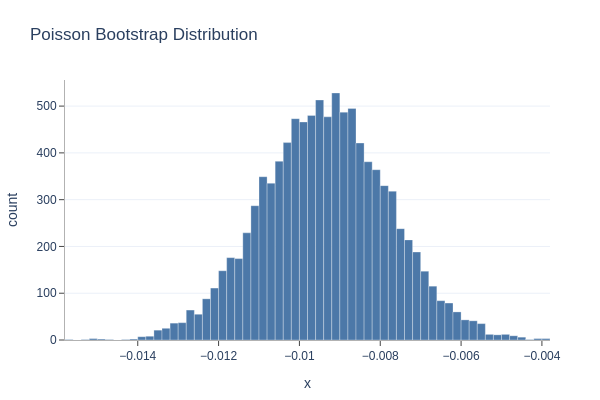

In [134]:
px.histogram(x=ctr_poisson_diff, nbins=100, title='Poisson Bootstrap Distribution')

**Observations:**

- Zero does not fall within the 95% confidence interval, therefore we reject the null hypothesis.
- Poisson bootstrap found statistically significant differences in CTR between groups.
- The main problem is the violation of Poisson assumption.

## Delta Method

- The Delta method is similar to a t-test, but the variance estimate is calculated using a special formula for the ratio of two random variables.
- The Delta method is used to address the problem of data dependency.
- It allows comparing non-user-level metrics using aggregated data.
- This method involves finding (approximating) the variance of a ratio metric.
- It significantly outperforms bootstrap in terms of computational complexity and speed.
- Disadvantages of the Delta method:
    - Inability to apply variance reduction techniques
    - Because we are still working with a ratio metric, not a user-level metric.

Let's write a function for the delta method.

In [135]:
def check_delta_method(likes_control, views_control, likes_test, views_test):
    """Hypothesis testing using the delta method."""
    result = {}
    control_data = ('control', likes_control, views_control)
    test_data = ('test', likes_test, views_test)
    for group_name, likes, views in [control_data, test_data]:
        if len(likes) != len(views):
            raise ValueError(f"The lengths of the likes and views arrays do not match for the group {group_name}")
        n_users = len(views)
        mean_x, mean_y = np.mean(likes), np.mean(views)
        var_x, var_y = np.var(likes, ddof=1), np.var(views, ddof=1)
        cov_xy = np.cov(likes, views, ddof=1)[0, 1]
        # Point estimate of the metric.
        pe_metric = np.sum(likes) / np.sum(views)
        # Variance estimate of the metric.
        var_metric = (
            var_x / mean_y ** 2
            - 2 * (mean_x / mean_y ** 3) * cov_xy
            + (mean_x ** 2 / mean_y ** 4) * var_y
        ) / n_users
        result[f'pe_metric_{group_name}'] = pe_metric
        result[f'var_metric_{group_name}'] = var_metric
    var_total = result['var_metric_control'] + result['var_metric_test']
    delta = result['pe_metric_test'] - result['pe_metric_control']
    t = delta / np.sqrt(var_total)
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

Formulate the null and alternative hypotheses.

- H0: The mean global CTR in the control and test groups are equal.
- H1: The mean global CTR in the control and test groups are not equal.

Set the significance level to 0.05.

In [136]:
alpha = 0.05

Run the test.

In [137]:
likes_control, views_control = df_control['likes'], df_control['views']
likes_test, views_test = df_test['likes'], df_test['views']
pvalue = check_delta_method(likes_control, views_control, likes_test, views_test)
if pvalue < alpha:
    print(f'Reject the null hypothesis.\nMean CTR in control and test groups are not equal.\npvalue = {pvalue}')
else:
    print(f'Fail to reject the null hypothesis.\nMean CTR in control and test groups are equal.\npvalue = {pvalue}')
print(f"Difference in global CTR (test - control): {observed_diff:.6f}")

Reject the null hypothesis.
Mean CTR in control and test groups are not equal.
pvalue = 2.2349817552225204e-09
Difference in global CTR (test - control): -0.009354


**Observations:**

- p-value is below the significance level, therefore we reject the null hypothesis.
- According to the delta method, there is a statistically significant difference in CTR between the groups.
- In the test group, CTR is lower than in the control group by 0.009354.

## T-test on Bucket-Transformed Data

- T-test on bucket-transformed data can be robust to bimodality.
- Although theoretically, the bimodality effect might persist.

Split users in each group into 50 buckets.

In [138]:
def hash_split(id, salt='exp_1', n_buckets=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_buckets

In [139]:
df['bucket'] = (
    df.groupby('group', observed=True)['user_id']
    .transform(
        lambda x: x.apply(hash_split, n_buckets=50)
    )
)

Examine the distribution.

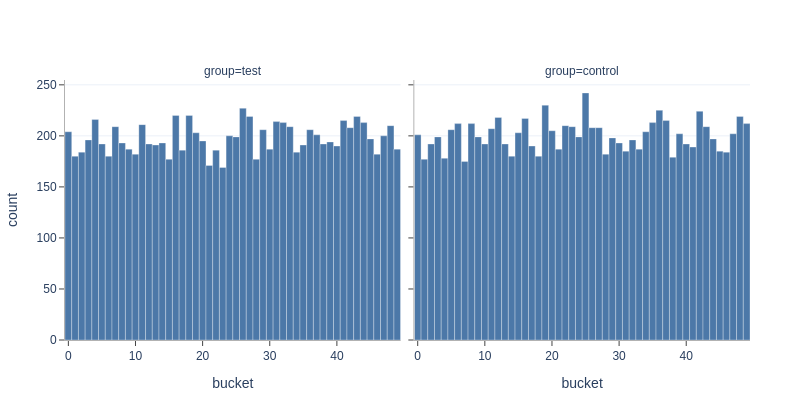

In [140]:
px.histogram(
    df
    , x='bucket'
    , facet_col='group'
    , nbins=50
    , width=800
)

Calculate CTR for buckets.

In [141]:
df_bucket = (
    df.groupby(['bucket', 'group'], as_index=False).agg(
        likes = ('likes', 'sum')
        , views = ('views', 'sum')
    )
)
df_bucket['ctr'] = df_bucket.likes / df_bucket.views

Examine the distribution.

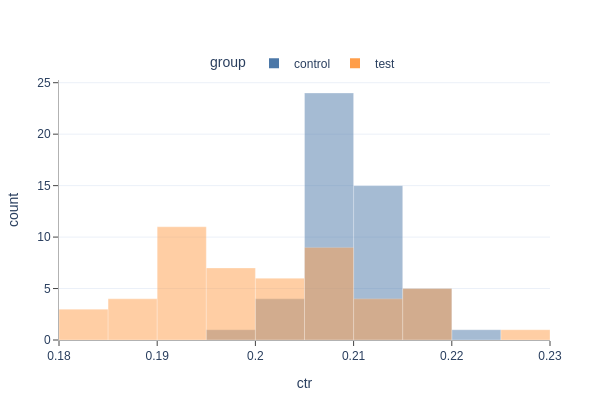

In [142]:
px.histogram(
    df_bucket
    , x='ctr'
    , color='group'
    , barmode='overlay'
    , nbins=10
)

Formulate null and alternative hypotheses.

- H0: Mean global bucket CTR in control and test groups are equal
- H1: Mean global bucket CTR in control and test groups are not equal

Test variance equality using Levene's test.

- H0: Variances in control and test groups are equal
- H1: Variances in control and test groups are not equal

Set significance level to 0.05.

In [143]:
pg.homoscedasticity(df_bucket, dv='ctr', group='group')

,W,pval,equal_var
levene,29.79,0.00,False


**Result:**

- At significance level 0.05, we reject the null hypothesis of equal variances since p-value is less than the significance level.

Since variances are not equal, we will use Welch's test.

Set significance level to 0.05.

In [144]:
ctr_bucket_control = df_bucket[df_bucket.group == 'control'].ctr
ctr_bucket_test = df_bucket[df_bucket.group == 'test'].ctr

In [145]:
pg.ttest(ctr_bucket_test, ctr_bucket_control, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.45,67.15,two-sided,0.00,"[-0.01, -0.01]",1.09,3.374e+04,1.00


In [146]:
print(f'Difference in global bucket CTR (test - control) = {ctr_bucket_test.mean() - ctr_bucket_control.mean():.2f}')

Difference in global bucket CTR (test - control) = -0.01


**Observations:**

- p-value is below the significance level, therefore we reject the null hypothesis.
- According to Welch's test, global bucket CTR differs between groups. The test group value is lower.
- Note that 0 does not fall within the confidence interval, which also confirms the result.

## Mann-Whitney on Bucket-Transformed Data

- Since group variances are different, the Mann-Whitney test is unpredictable for comparing means. Even if there are no differences in means, it might detect differences in distributions.
- Considering we need to compare mean values, its use in this case would not be a very good choice.

Formulate null and alternative hypotheses.

- H0: The probability that a randomly selected global bucket CTR value from the test group will exceed a randomly selected global bucket CTR value from the control group equals the probability of the opposite outcome.

- H1: The probability that a randomly selected global bucket CTR value from the test group will exceed a randomly selected global bucket CTR value from the control group is not equal to 0.5.

Set significance level to 0.05.

In [147]:
pg.mwu(ctr_bucket_test, ctr_bucket_control)

,U-val,alternative,p-val,RBC,CLES
MWU,570.00,two-sided,0.00,-0.54,0.23


**Observations:**

- p-value is below the significance level, therefore we reject the null hypothesis.
- According to the Mann-Whitney test, one of the global bucket CTR distributions statistically significantly dominates the other.
- However, this result provides little business value since we essentially compared distributions, not means.

## T-test on Linearized Metric

- The essence of linearization is to represent each user's contribution to the difference in global CTR.
- The t-test on the linearized metric essentially tests the same hypothesis as Poisson bootstrap.
- Linearization creates a metric where differences in means strongly correlate with differences in global CTR.

Use global CTR from the control group as reference.

In [148]:
global_ctr = df[df['group'] == 'control']['likes'].sum() / df[df['group'] == 'control']['views'].sum()

If the user behaved "like average", they would have gathered this many likes

```python
df['views'] * global_ctr
```

For each user, create a linearized metric by subtracting expected from actual

In [149]:
df['linearized_likes'] = df['likes'] - df['views'] * global_ctr

Examine the distribution.

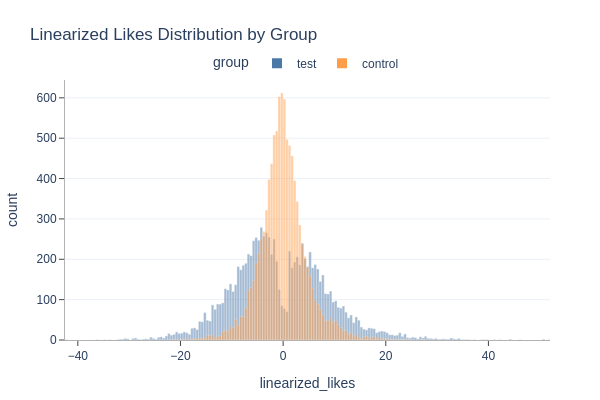

In [150]:
px.histogram(
    df
    , x='linearized_likes'
    , color='group'
    , barmode='overlay'
    , title='Linearized Likes Distribution by Group'
)

**Observations:**

- Visually noticeable variance reduction.
- Bimodality remains but is less pronounced.

Formulate null and alternative hypotheses.

- H0: Mean value of the linearized metric in control and test groups are equal
- H1: Mean value of the linearized metric in control and test groups are not equal

Test variance equality using Levene's test.

- H0: Variances in control and test groups are equal
- H1: Variances in control and test groups are not equal

Set significance level to 0.05.

In [151]:
pg.homoscedasticity(df, dv='linearized_likes', group='group')

,W,pval,equal_var
levene,"3,535.16",0.00,False


**Result:**

- At significance level 0.05, we reject the null hypothesis of equal variances since p-value is less than the significance level.

Since variances are not equal, we will use Welch's test.

In [152]:
linearized_likes_control = df[df['group'] == 'control'].linearized_likes
linearized_likes_test = df[df['group'] == 'test'].linearized_likes

Examine the difference in mean values.

In [153]:
linearized_likes_test.mean() - linearized_likes_control.mean()

np.float64(-0.6245118559393538)

Set significance level to 0.05.

In [154]:
pg.ttest(linearized_likes_test, linearized_likes_control, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.94,"14,482.89",two-sided,0.00,"[-0.83, -0.42]",0.08,6.981e+05,1.00


**Observations:**

- p-value is below the significance level, therefore we reject the null hypothesis.
- According to Welch's test, there is a statistically significant difference in the linearized metric between groups.
- Note that pingouin shows power of 1.
- Variance decreased and the t-test became more powerful.

## Permutation Test

- Permutation test helps understand how statistically significant the effect we see in the experiment is.
- Its essence is:
    - We observed a difference original_diff
    - If the groups were random (no effect), how often would we get the same or greater difference?
- It has the same problems as Mann-Whitney. It can detect differences in distributions even with equal means.

Formulate null and alternative hypotheses.

- H0: Mean CTR in control and test groups are equal
- H1: Mean CTR in control and test groups are not equal

Set significance level to 0.05.

In [155]:
alpha = 0.05

Create a function for permutation test.

In [156]:
def permutation_test(x, y, n_permutations=10_000):
    combined = np.concatenate([x, y])
    len_x = len(x)
    perm_diffs = []
    for _ in range(n_permutations):
        np.random.shuffle(combined)
        perm_x = combined[:len_x]
        perm_y = combined[len_x:]
        perm_diffs.append(np.mean(perm_y) - np.mean(perm_x))
    
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    return np.array(perm_diffs), p_value

In [157]:
observed_diff = ctr_test.mean() - ctr_control.mean()
perm_diffs, p_value = permutation_test(ctr_test, ctr_control)
print(f'Observed difference in means: {observed_diff:.1f}')
print(f"Permutation p-value: {p_value:.3f}")
if p_value < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Observed difference in means: -0.0
Permutation p-value: 0.681
Fail to reject the null hypothesis


**Observations:**

- Since p-value is higher than the significance level, we fail to reject the null hypothesis.
- The permutation test did not find a statistically significant difference between mean CTR in control and test groups.
- The effect is truly absent or too small relative to data variability for the permutation test to detect.

Examine the distribution of permutation mean differences.

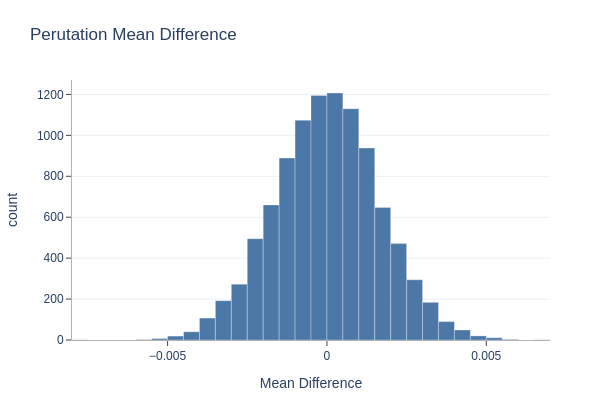

In [158]:
px.histogram(
    perm_diffs
    , title='Perutation Mean Difference'
    , nbins=50
).update_layout(showlegend=False, xaxis_title_text='Mean Difference')

## Post-stratification

- Post-stratification is used to reduce variance.
    - In post-stratification, sample objects are "reweighted" so that stratum proportions in samples match stratum proportions in the population by calculating stratifiedmeans.
- Post-stratification only makes sense when two conditions are met simultaneously:
    - Strata have different mean metric values (e.g., CTR_male ≠ CTR_female).
    - Stratum proportions differ between control and test groups (e.g., control has 60% male and 40% female, while test has 50% male and 50% female).

Based on data analysis, these conditions are not met for all dimensions, but for practice we'll perform post-stratification by gender.

Examine how users are distributed by gender.

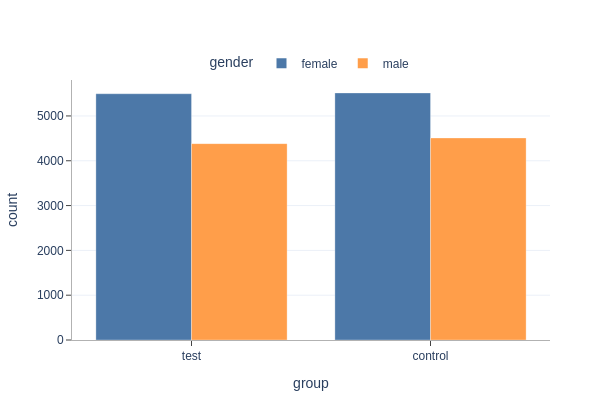

In [159]:
px.histogram(
    df
    , x='group'
    , color='gender'
    , barmode='group'
)

**Observations:**

- As we've already seen, proportions between groups are approximately equal.

Examine the distribution of mean CTR.

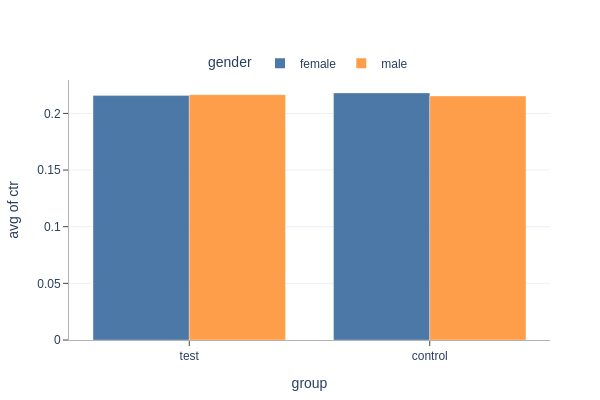

In [160]:
px.histogram(
    df
    , y='ctr'
    , x='group'
    , color='gender'
    , histfunc='avg'
    , barmode='group'
)

**Observations:**

- As we've already seen, CTR differs only slightly between men and women.

Post-stratification procedure:

1. Split users into groups by stratum membership
2. Calculate mean value for each group
3. Multiply means by stratum proportions in the population (0.44 and 0.56 respectively)
4. Sum everything

Calculate stratum proportions in the total population (combined data)

In [161]:
%%sql users_by_gender <<
SELECT 
    multiIf(
        gender = 1, 'female'
        , gender = 0, 'male'
        , 'unknown'
    ) as gender
    , uniq(user_id) users
FROM
    feed_actions
GROUP BY
    gender

Returning data to local variable users_by_gender


In [162]:
population_proportions = (
    users_by_gender.set_index('gender')['users']
    / users_by_gender['users'].sum()
)
print("Proportions in total population:")
print(population_proportions)

Proportions in total population:
gender
male     0.45
female   0.55
Name: users, dtype: float64


Calculate raw means (unadjusted means)

In [163]:
raw_control_mean = df[df['group'] == 'control']['ctr'].mean()
raw_test_mean = df[df['group'] == 'test']['ctr'].mean()
print(f"Raw CTR Control: {raw_control_mean:.3f}\nRaw CTR Test: {raw_test_mean:.3f}")

Raw CTR Control: 0.217
Raw CTR Test: 0.216


Create a function to calculate post-stratified means.

In [164]:
def calculate_stratified_mean(group_df, population_weights):
    stratified_means = []
    for stratum, weight in population_weights.items():
        stratum_mean = group_df[group_df['gender'] == stratum]['ctr'].mean()
        stratified_means.append(stratum_mean * weight)
    return np.sum(stratified_means)

Apply to both groups.

In [165]:
stratified_control = calculate_stratified_mean(
    df[df['group'] == 'control'], population_proportions
)
stratified_test = calculate_stratified_mean(
    df[df['group'] == 'test'], population_proportions
)

In [166]:
print(f"Stratified Raw CTR Control: {stratified_control:.3f}\nStratified Raw CTR Test: {stratified_test:.3f}")

Stratified Raw CTR Control: 0.217
Stratified Raw CTR Test: 0.216


Compare differences

In [167]:
raw_diff = raw_test_mean - raw_control_mean
stratified_diff = stratified_test - stratified_control

print(f"\nRaw difference: {raw_diff:.3f}")
print(f"Stratified difference: {stratified_diff:.3f}")


Raw difference: -0.001
Stratified difference: -0.001


**Observations:**

- As expected, the differences are minimal.

## T-test with CUPED Transformed Metric

Controlled Experiment Using Pre-Experimental Data

- Used for variance reduction
- Conceptually, CUPED uses the idea: subtracting predicted value from actual value,
    - but the prediction here is built using correlation between historical and current data: the stronger the relationship,
    - the more we trust the prediction and adjust the metric. Conversely, if there's no relationship,
    - the metric remains unchanged when using CUPED.

We need to get historical data from the database for users who participated in the experiment.
We'll use data from the week before the experiment.

In [168]:
%%sql df_hist <<
WITH exp_users as (
SELECT
    user_id
FROM
    feed_actions
WHERE
    toDate(time) BETWEEN '2025-08-02' and '2025-08-08'
    and exp_group in (1, 2)
GROUP BY
    user_id
)
, hist_metrics as (
    SELECT
        user_id
        , countIf(action = 'like') as hist_likes
        , countIf(action = 'view') as hist_views
        , ifNull(hist_likes / nullIf(hist_views, 0), 0) as hist_ctr
    FROM
        feed_actions
    WHERE
        toDate(time) BETWEEN '2025-07-26' and '2025-08-01'
    GROUP BY
        user_id        
)
SELECT
    eu.user_id
    , ifNull(hm.hist_ctr, 0) as hist_ctr
    , if(hm.user_id != 0, 1, 0) as has_history 
FROM
    exp_users eu
    LEFT JOIN hist_metrics hm ON eu.user_id = hm.user_id

Returning data to local variable df_hist


Merge with experimental data.

In [169]:
df = df.merge(df_hist, on='user_id')

Let's see what percentage of users have no history.

In [170]:
(df.has_history == 0).mean()

np.float64(0.381263507061366)

**Observations:**

- 38% is a lot.
- For these users, we'll use the average historical CTR across all data, but accounting for dimensions.

In [171]:
%%sql df_hist_all <<
SELECT
    multiIf(
        gender = 1, 'female'
        , gender = 0, 'male'
        , 'unknown'
    ) as gender
    , multiIf(
        age < 25, '<25'
        , age between 25 and 40, '25-40'
        , age between 41 and 55, '41-55' 
        , age >= 56, '56+'
        , 'unknown'
    ) as age_group      
    , source
    , os
    , country
    , city
    , countIf(action = 'like') as hist_likes
    , countIf(action = 'view') as hist_views
    , ifNull(hist_likes / nullIf(hist_views, 0), 0) as hist_ctr
FROM
    feed_actions
WHERE
    toDate(time) BETWEEN '2025-07-26' and '2025-08-01'
GROUP BY
    gender
    , age_group
    , source
    , os
    , country
    , city              

Returning data to local variable df_hist_all


Merge the data.
Replace missing values with global historical CTR.

In [172]:
df.set_index(['gender', 'age_group', 'source', 'os', 'country', 'city'], inplace=True)
mask = df.has_history == 0
df.loc[mask, 'hist_ctr'] = (
    df_hist_all.set_index(['gender', 'age_group', 'source', 'os', 'country', 'city'])
    ['hist_ctr']
)
df.reset_index(inplace=True)
global_mean = df_hist_all['hist_ctr'].mean()
df['hist_ctr'] = df['hist_ctr'].fillna(global_mean)

Examine the distribution and compare statistics.

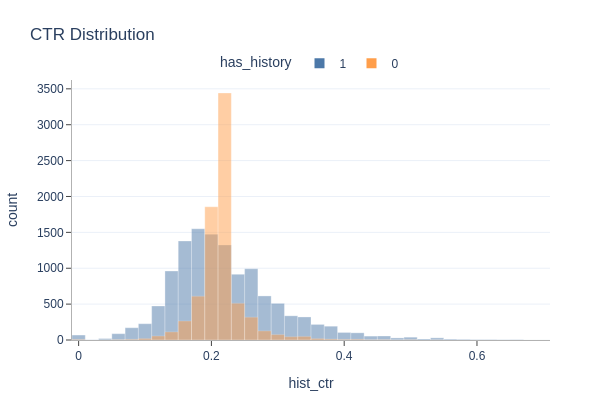

In [173]:
px.histogram(
    df
    , x='hist_ctr'
    , color='has_history'
    , nbins=50
    , barmode='overlay'
    , title='CTR Distribution'
)

In [174]:

comparison = df.groupby('has_history').agg({
    'hist_ctr': ['mean', 'std', 'count']
}).round(4)
print("\nComparison of statistics:")
print(comparison)


Comparison of statistics:
            hist_ctr            
                mean  std  count
has_history                     
0               0.21 0.04   7586
1               0.22 0.08  12311


**Observations:**

- Mean values are close.
- Standard deviations differ. This is normal since group means are less variable.

Select CTR during the experiment.

In [175]:
control_mask = df.group == 'control'
test_mask = df.group == 'test'

In [176]:
y_control = df[control_mask]['ctr'].values
y_test = df[test_mask]['ctr'].values

Covariates will be historical CTR.

In [177]:
x_control = df[control_mask]['hist_ctr'].values 
x_test = df[test_mask]['hist_ctr'].values

Examine correlations.

In [178]:
corr_control = np.corrcoef(x_control, y_control)[0, 1]
corr_test = np.corrcoef(x_test, y_test)[0, 1]

print(f"Correlation control: {corr_control:.3f}")
print(f"Correlation test: {corr_test:.3f}")

Correlation control: 0.026
Correlation test: 0.009


**Observations:**

- Low correlation indicates that historical CTR practically doesn't predict current CTR. This is an extremely weak relationship.
- Possibly influenced by the fact that the test has many new users who weren't present before.
- Possibly users changed their behavior during the experiment.

Calculate parameter θ for CUPED.

In [179]:
def calculate_theta(y, x):
    covariance = np.cov(y, x)[0, 1]
    variance_x = np.var(x)     
    theta = covariance / variance_x if variance_x > 0 else 0
    return theta

theta_control = calculate_theta(y_control, x_control)
theta_test = calculate_theta(y_test, x_test)

print(f"Theta control: {theta_control:.4f}")
print(f"Theta test: {theta_test:.4f}")

Theta control: 0.0315
Theta test: 0.0194


Apply CUPED to both groups.

In [180]:
y_cuped_control = y_control - theta_control * x_control
y_cuped_test = y_test - theta_test * x_test

Examine the difference in means.

In [181]:
y_cuped_test.mean() - y_cuped_control.mean()

np.float64(0.0019241573805137135)

In [182]:
df_cuped = (
    pd.concat([
        pd.DataFrame({'y_cuped': y_cuped_control, 'group': 'control'})
        , pd.DataFrame({'y_cuped': y_cuped_test, 'group': 'test'})
    ])
)

Examine the distributions.

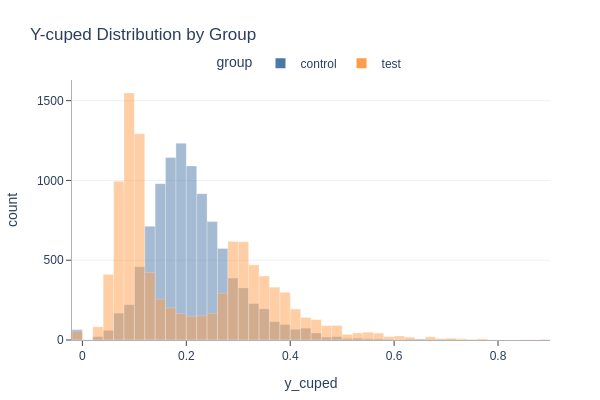

In [183]:
px.histogram(
    df_cuped
    , x='y_cuped'
    , color='group'
    , barmode='overlay'
    , title='Y-cuped Distribution by Group'
    , nbins=50
)

Formulate null and alternative hypotheses.
- H0: Mean value of the transformed metric in control and test groups are equal
- H1: Mean value of the transformed metric in control and test groups are not equal

Test variance equality using Levene's test.
- H0: Variances in control and test groups are equal
- H1: Variances in control and test groups are not equal

Set significance level to 0.05.

In [184]:
pg.homoscedasticity(df_cuped, dv='y_cuped', group='group')

,W,pval,equal_var
levene,"2,766.73",0.00,False


**Result:**
- At significance level 0.05, we reject the null hypothesis of equal variances since p-value is less than the significance level.

Since variances are not equal, we will use Welch's test.

In [185]:
y_cuped_control = df_cuped[df_cuped['group'] == 'control'].y_cuped
y_cuped_test = df_cuped[df_cuped['group'] == 'test'].y_cuped

Examine the difference in mean values.

In [186]:
y_cuped_test.mean() - y_cuped_control.mean()

np.float64(0.0019241573805137135)

Set significance level to 0.05.

In [187]:
pg.ttest(y_cuped_test, y_cuped_control, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.16,"15,808.39",two-sided,0.25,"[-0.0, 0.01]",0.02,0.031,0.21


**Observations:**
- p-value is higher than the significance level, therefore we fail to reject the null hypothesis.
- According to Welch's test, there is no statistically significant difference in the transformed metric between groups.
- Note that pingouin shows power of 0.21.